In [335]:
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import sys

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.append("../src")
from installations.plot import plot_gantt, plot_durations

%matplotlib notebook
plt.style.use('fivethirtyeight')
print(mpl.rcParams['font.family'])
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
print(font)

installation_data_dir = "../data/windfarms/matching_windfarms//"

['sans-serif']
/home/san/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf


In [336]:
installations_metadata = pd.read_csv("../data/windfarms/matching_windfarms/matching_windfarms.csv")
windfarm_database = pd.read_excel("../data/windfarms/windfarms-complete_turbines.ods", engine="odf")
windfarm_database.set_index("index", inplace=True)
windfarm_database.sort_index(inplace=True)

In [337]:
windfarm_database.columns

Index(['name', 'latitude', 'longitude', 'n_turbines', 'turbine_power',
       'windfarm_capacity', 'turbine_installation_start',
       'turbine_installation_end', 'turbine_installation_vessel',
       'days_per_foundation_lit', 'days_per_turbine_lit', 'days_set_lit',
       'Source', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')

In [338]:
installations = dict()
for infile in sorted(glob.glob(os.path.join(installation_data_dir, "*cluster-*.csv"))):
    installation_index = int(os.path.basename(infile).split("_")[0])
    vessel_name = installations_metadata.loc[installation_index].vessel_name
    windfarm_database_index = installations_metadata.loc[installation_index].known_windfarms_index
    windfarm = os.path.basename(infile).split("_")[1]
    installations[windfarm_database_index] = pd.read_csv(infile)
    installations[windfarm_database_index].begin = pd.to_datetime(installations[windfarm_database_index].begin)
    installations[windfarm_database_index].end = pd.to_datetime(installations[windfarm_database_index].end)
    installations[windfarm_database_index].insert(loc=0, column='vessel', value=[vessel_name]*len(installations[windfarm_database_index]))
    installations[windfarm_database_index].insert(loc=0, column='windfarm', value=[windfarm]*len(installations[windfarm_database_index]))
    installations[windfarm_database_index].sort_values('begin', inplace=True)
    installations[windfarm_database_index].set_index('index', inplace=True)
    installations[windfarm_database_index].reset_index(drop=True, inplace=True)

In [344]:
for i, (key, windfarm) in enumerate(installations.items()):
    print(i+1, windfarm_database.loc[key]['name'], len(windfarm))
    if len(windfarm) > (nd := windfarm_database.loc[key].n_turbines):
        print(f'oh oh: {len(windfarm)} > {nd}')

1 Luchterduinen 4
2 Westermost Rough 32
3 Arkona 49
4 East Anglia One 11
5 Dudgeon 61
6 Gode Wind I & II 61
7 Hornsea 100
8 Borssele I/II 55
9 Humber Gateway 83
oh oh: 83 > 73
10 Northwind 52
11 Deutsche Bucht 14
12 Veja Mate 19
13 Galloper 11
14 Global Tech I 22
15 Butendiek 76
16 Moray East 68
17 Borkum Riffgrund 2 48
18 Borkum Riﬀgat 20
19 Merkur 59
20 Trianel Borkum 2 9
21 Gemini 29
22 Albatros 11
23 Nobelwind 41
24 Northwester 2 41
oh oh: 41 > 23
25 Kriegers Flak 72
26 Wikinger 64
27 Yunlin 11
28 Horns Rev 3 46
29 Sandbank 73
oh oh: 73 > 72
30 Teesside 25
31 Rampion 41
32 BARD Oﬀshore I 15
33 EnBW Baltic II (MP) 42
oh oh: 42 > 39


In [339]:
all_installations = pd.concat([installation for _, installation in installations.items()])
all_installations.sort_values("begin", inplace=True)
all_installations.reset_index(drop=True, inplace=True)
print(f"available turbine installations: {len(all_installations)}")

available turbine installations: 1365


In [306]:
average_installation = all_installations.duration.mean()
median_installation = all_installations.duration.median()
std_installation = all_installations.duration.std()
print(f"average installation time: {average_installation} (median: {median_installation}) +- {std_installation}")

average installation time: 47.33259747659748 (median: 27.049722222222226) +- 58.36211200923583


In [307]:
np.percentile(all_installations.duration, 90)

99.32405555555589

<IPython.core.display.Javascript object>


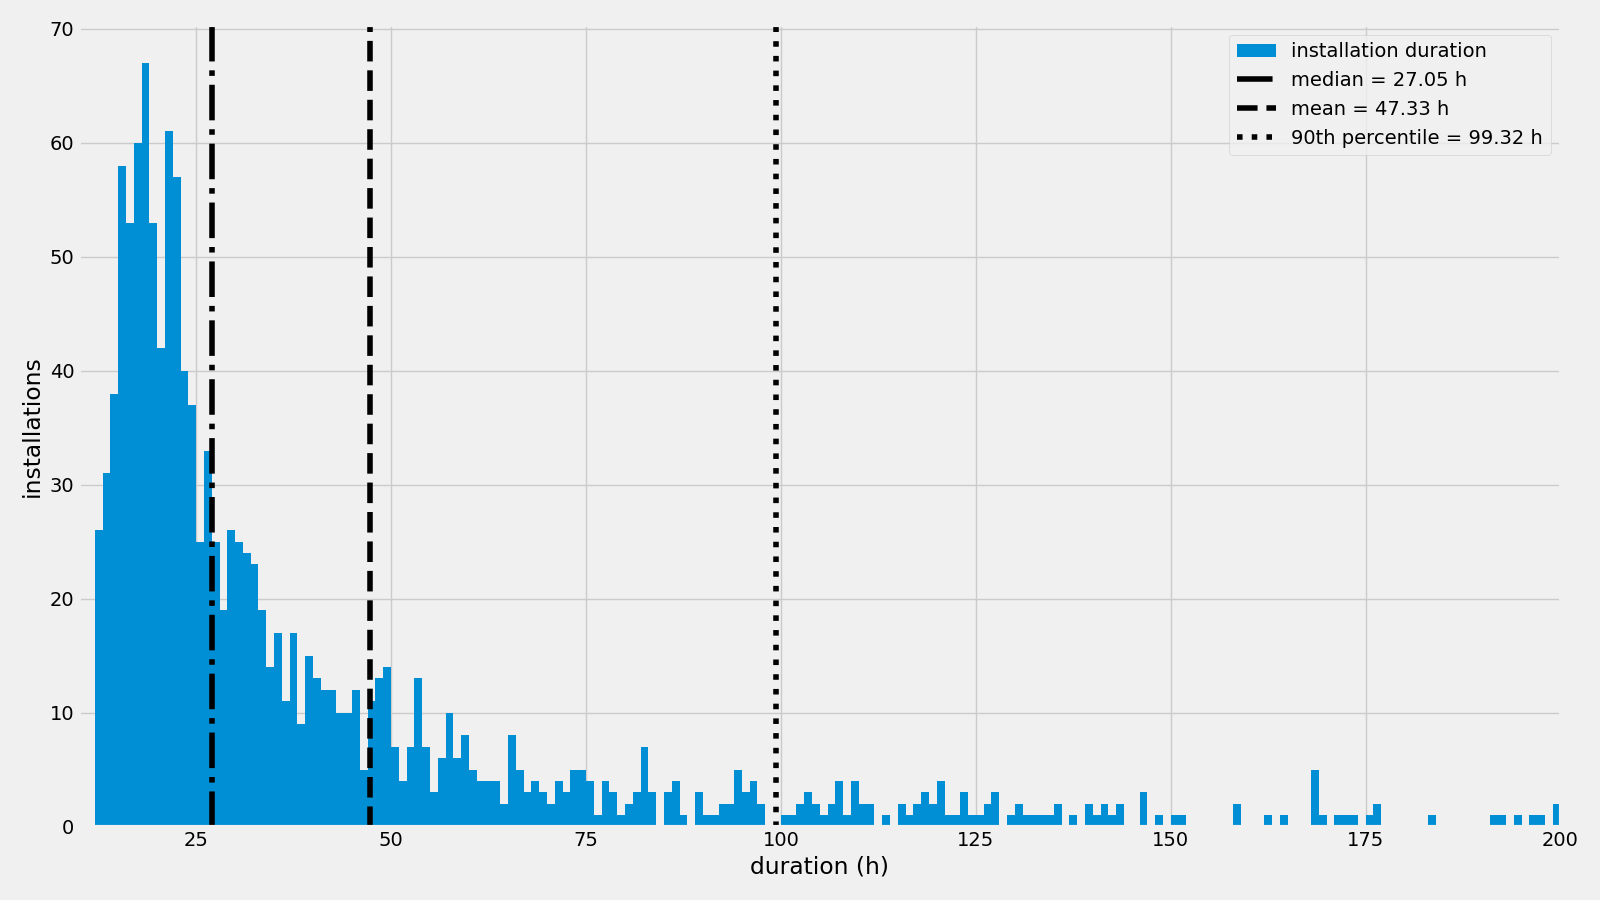

In [345]:
plt.figure(figsize=(16,9))
n, bins, patches = plt.hist(all_installations.duration, bins=[x for x in range(12, 720)], label='installation duration')
plt.xlim([10, 200])
plt.xlabel("duration (h)")
plt.ylabel("installations")
plt.axvline(x = all_installations.duration.median(), label=f'median = {all_installations.duration.median():1.2f} h', color='k', linestyle='-.')
plt.axvline(x = all_installations.duration.mean(), label=f'mean = {all_installations.duration.mean():1.2f} h', color='k', linestyle='--')
plt.axvline(x = np.percentile(all_installations.duration, 90), label=f'90th percentile = {np.percentile(all_installations.duration, 90):1.2f} h', color='k', linestyle='dotted')
plt.axvline()
plt.legend()
plt.tight_layout()


<IPython.core.display.Javascript object>


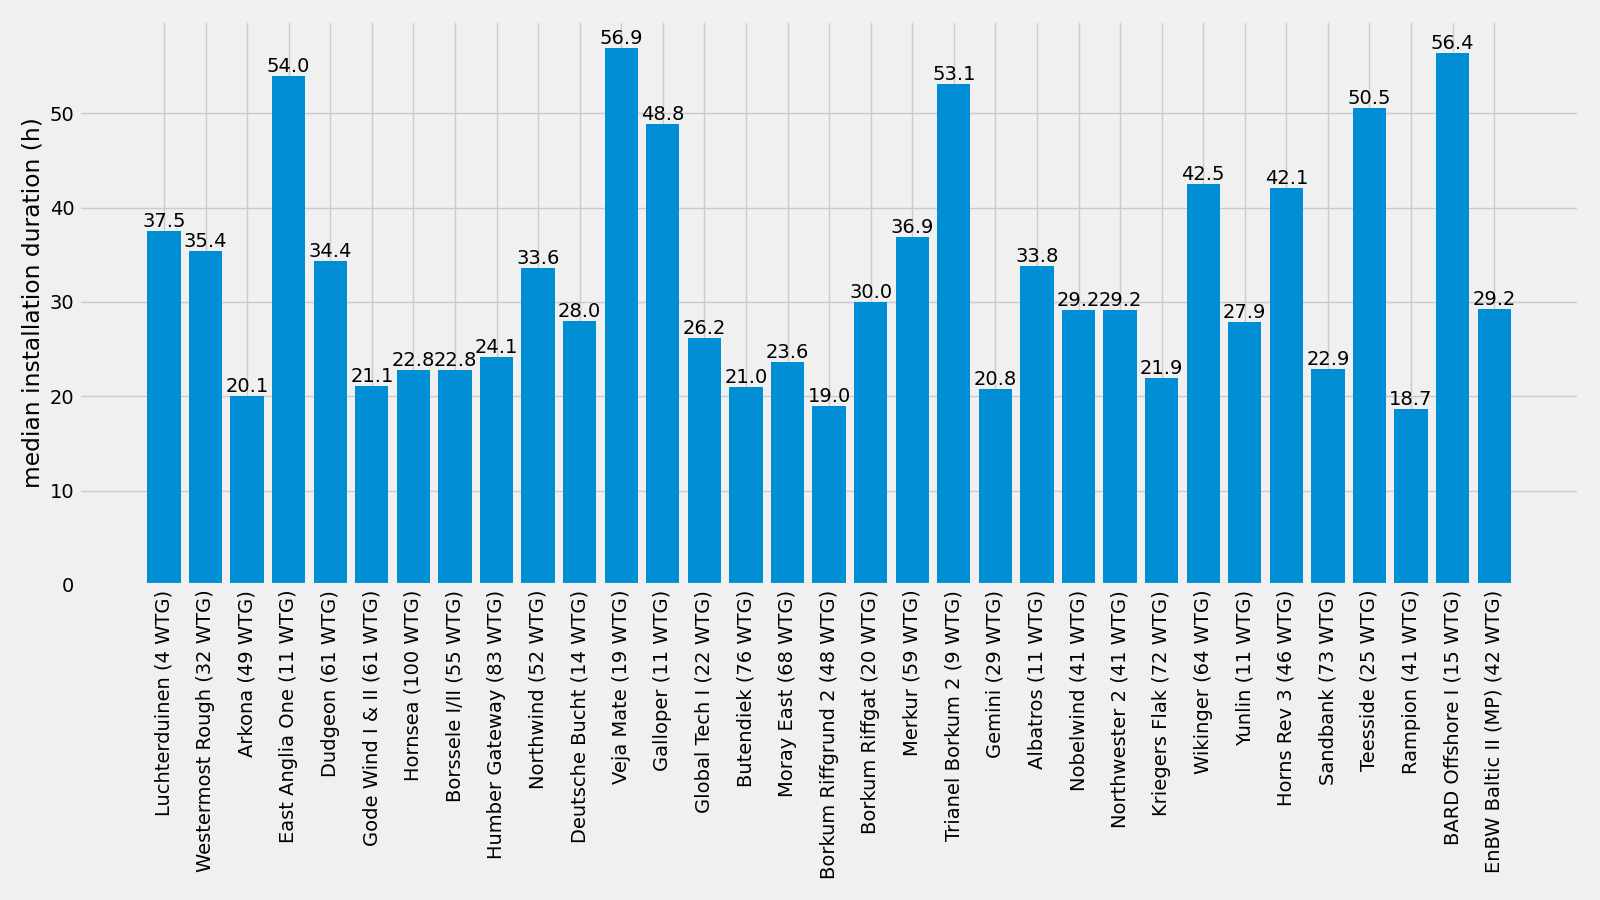

In [349]:
plt.figure(figsize=(16,9))
p1 = plt.bar(
    [x+1 for x in range(len(installations))], 
    [x.duration.median() for _, x in installations.items()],
)
plt.xticks(
    [x+1 for x in range(len(installations))],
    [ f"{windfarm_database.loc[x]['name']} ({len(y)} WTG)" for x, y in installations.items()],
    rotation=90
)
ax = plt.gca()
ax.bar_label(p1, [f"{x.duration.median():1.1f}" for _, x in installations.items()], label_type='edge')
plt.ylabel("median installation duration (h)")
plt.tight_layout()

<IPython.core.display.Javascript object>


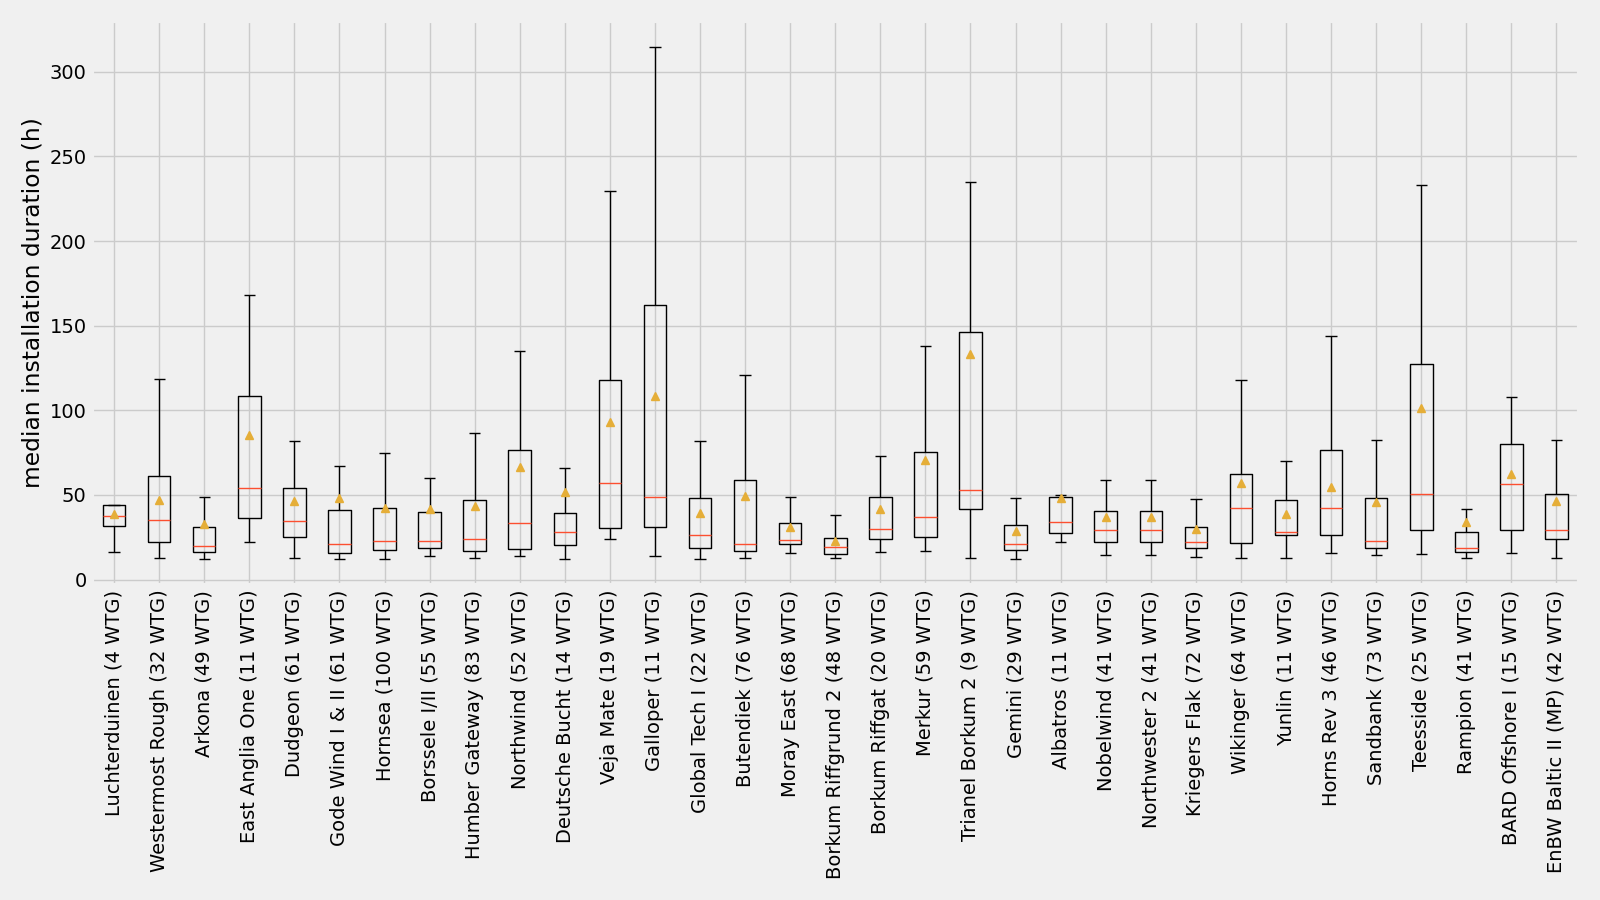

In [347]:
plt.figure(figsize=(16,9))
#p1 = plt.boxplot(
#    [x for x in range(len(installations))], 
#    [x.duration.median() for _, x in installations.items()],
#)
plt.boxplot([x.duration for x in installations.values()], showmeans=True, showfliers=False)
plt.xticks(
    [x + 1 for x in range(len(installations))],
    [ f"{windfarm_database.loc[i]['name']} ({len(y)} WTG)" for i, y in installations.items()],
    rotation=90
)
ax = plt.gca()
#ax.bar_label(p1, [ f"{windfarm_database.loc[i].turbine_power:1.1f}" for i, x in installations.items()], label_type='edge')
plt.ylabel("median installation duration (h)")
plt.tight_layout()

<IPython.core.display.Javascript object>


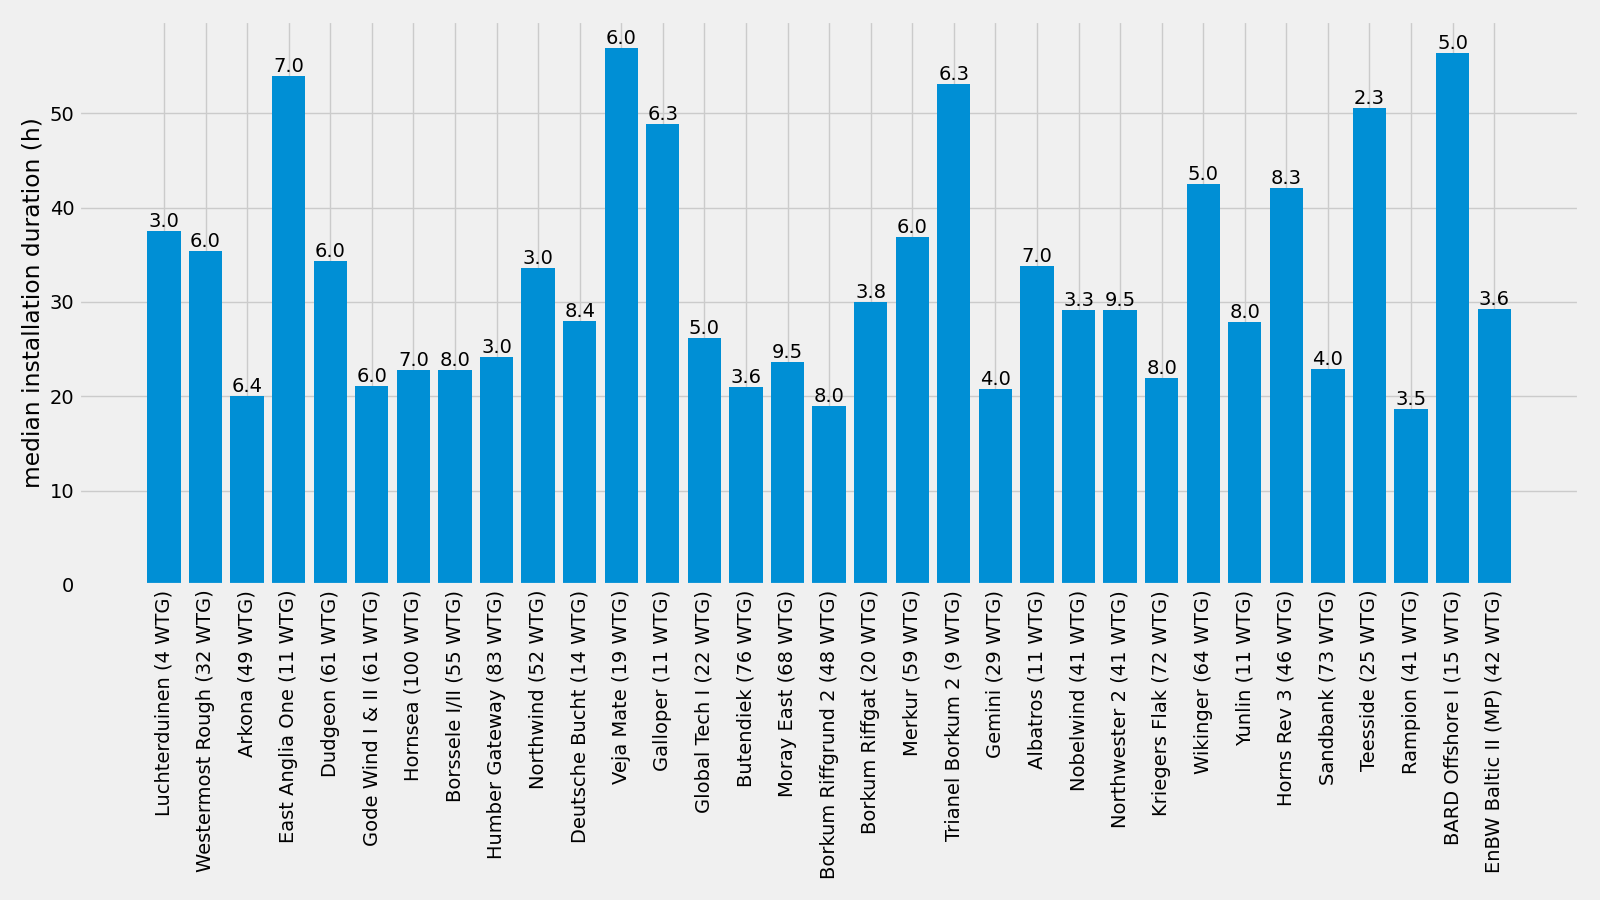

In [321]:
plt.figure(figsize=(16,9))
p1 = plt.bar(
    [x for x in range(len(installations))], 
    [x.duration.median() for _, x in installations.items()],
)
plt.xticks(
    [x for x in range(len(installations))],
    [ f"{windfarm_database.loc[i]['name']} ({len(y)} WTG)" for i, y in installations.items()],
    rotation=90
)
ax = plt.gca()
ax.bar_label(p1, [ f"{windfarm_database.loc[i].turbine_power:1.1f}" for i, x in installations.items()], label_type='edge')
plt.ylabel("median installation duration (h)")
plt.tight_layout()

<IPython.core.display.Javascript object>


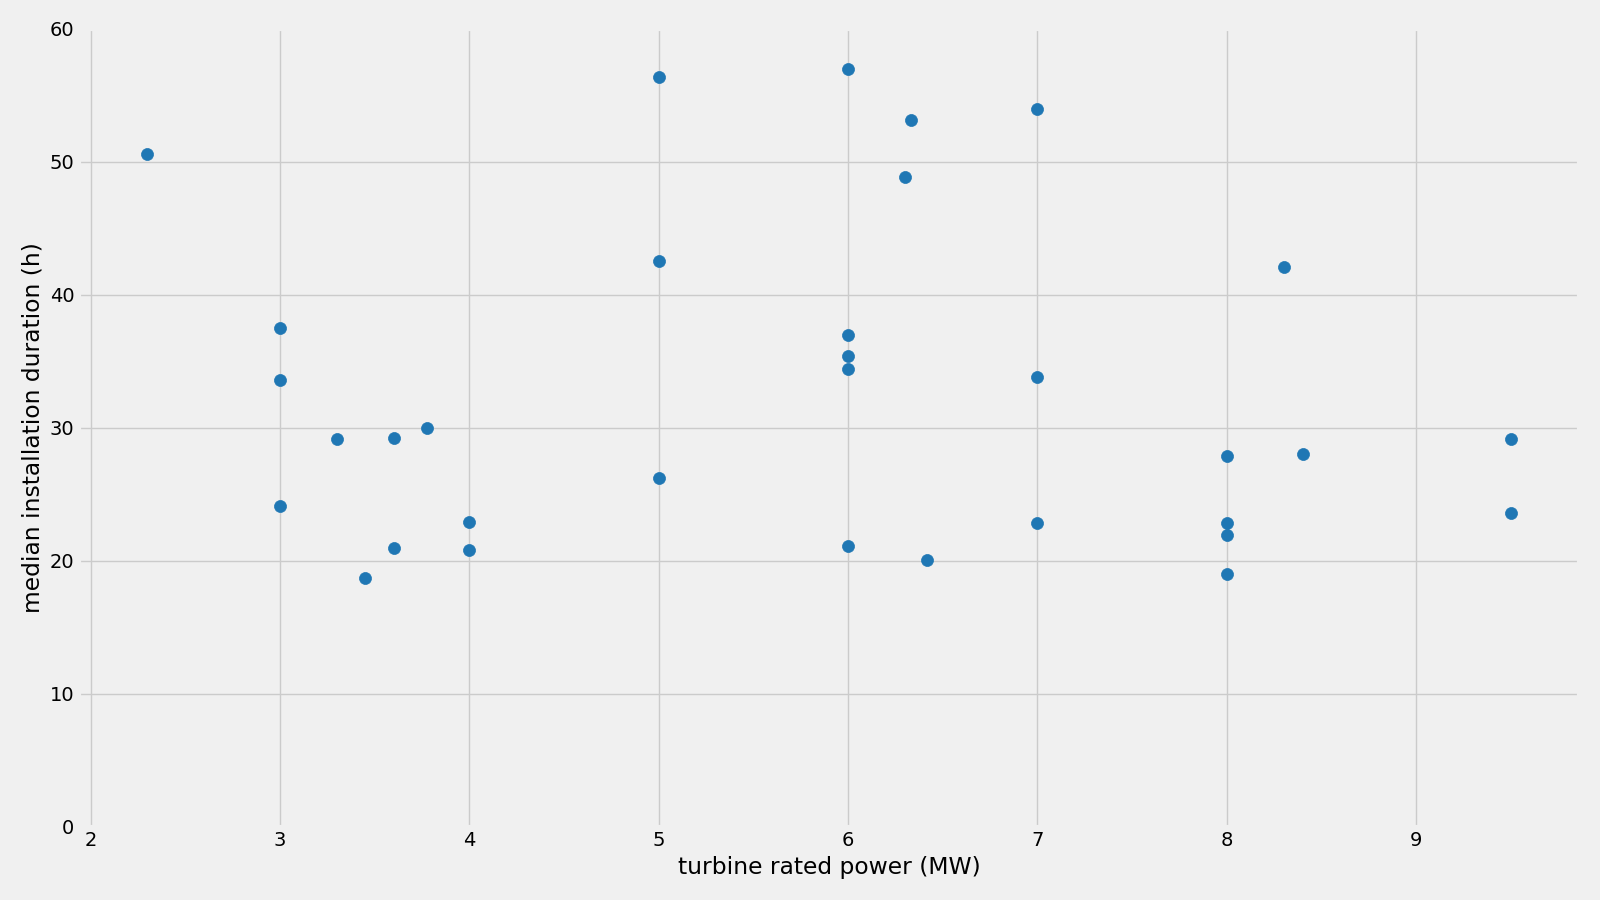

In [352]:
plt.figure(figsize=(16,9))
for i, installation in installations.items():
    power = windfarm_database.loc[i].turbine_power
    plt.scatter(power, installation.duration.median(), color='tab:blue', s=75)
plt.xlabel("turbine rated power (MW)")
plt.ylabel("median installation duration (h)")
plt.ylim([0, 60])
plt.tight_layout()

<IPython.core.display.Javascript object>


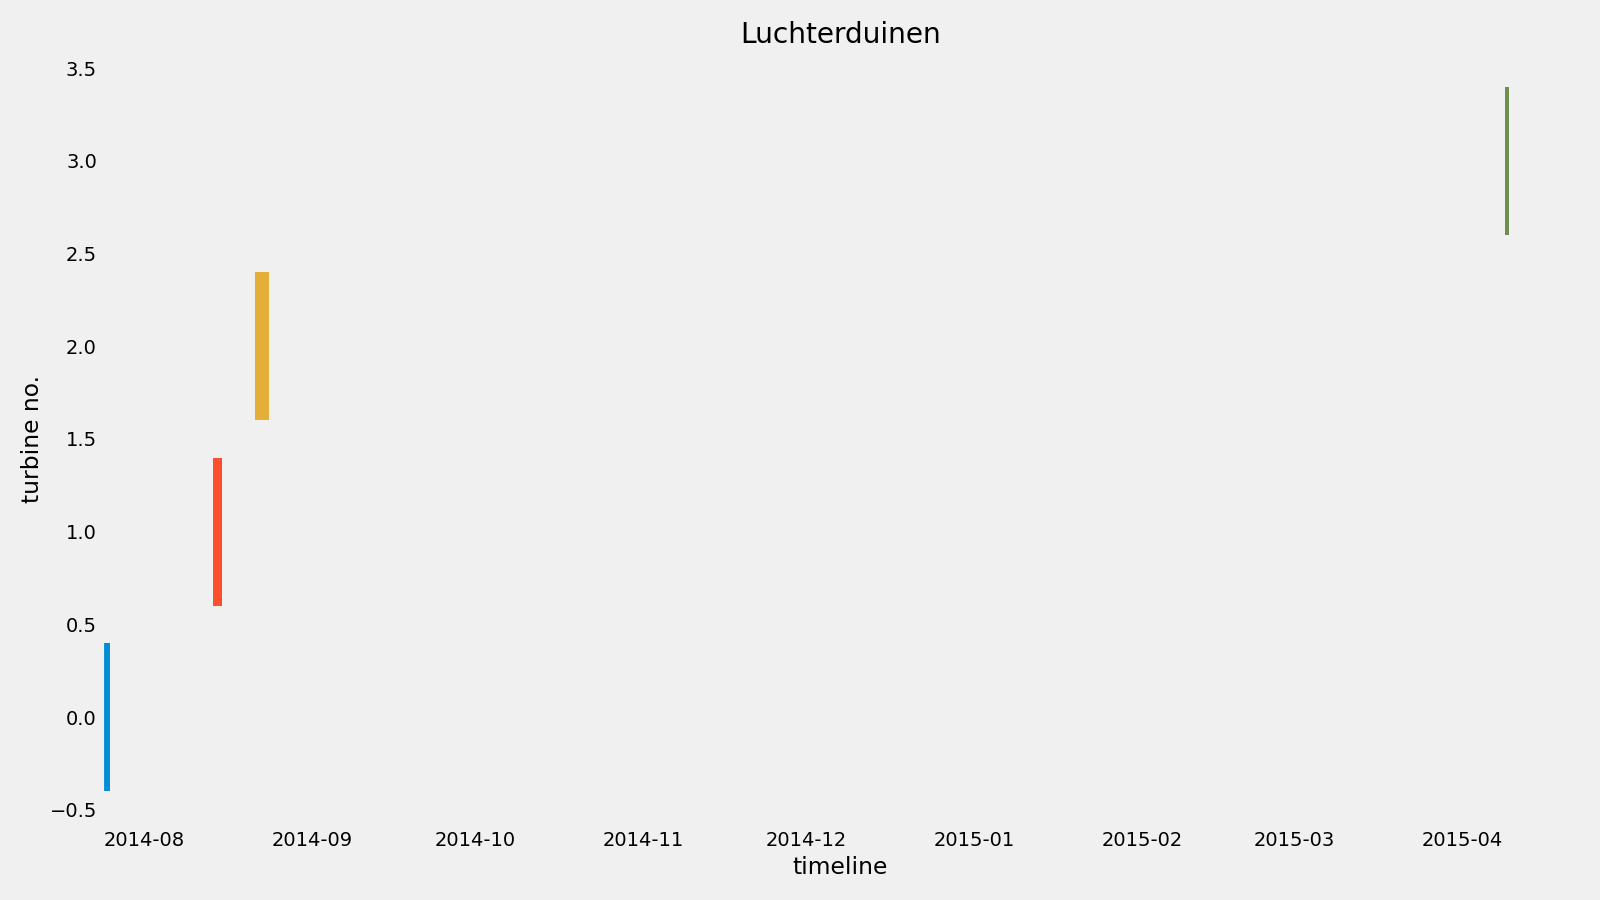

<IPython.core.display.Javascript object>


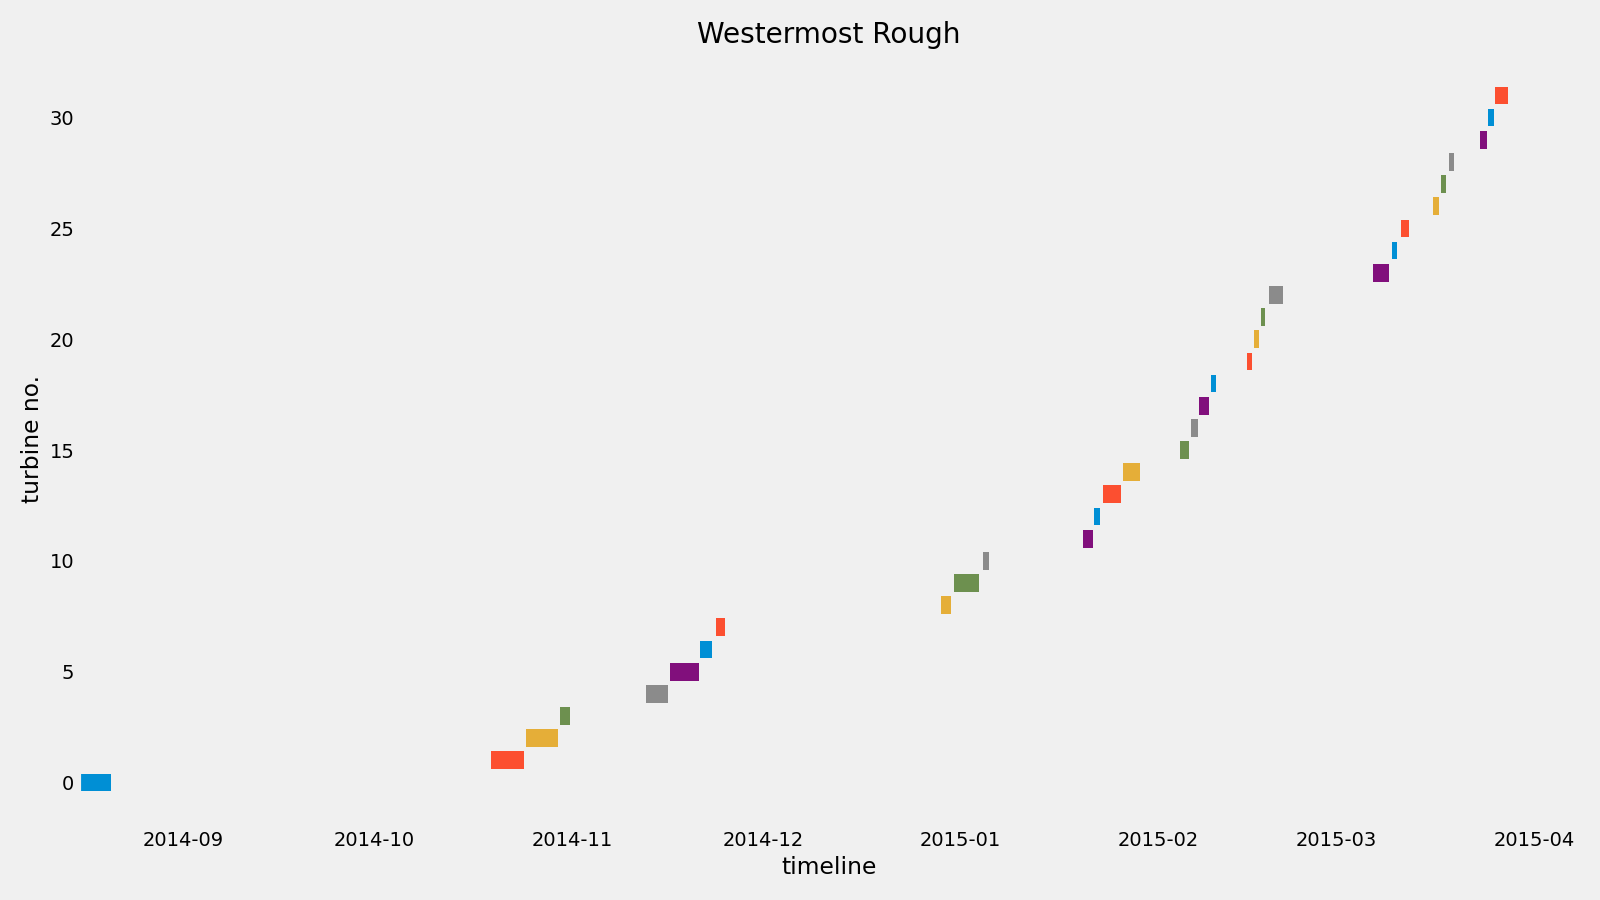

<IPython.core.display.Javascript object>


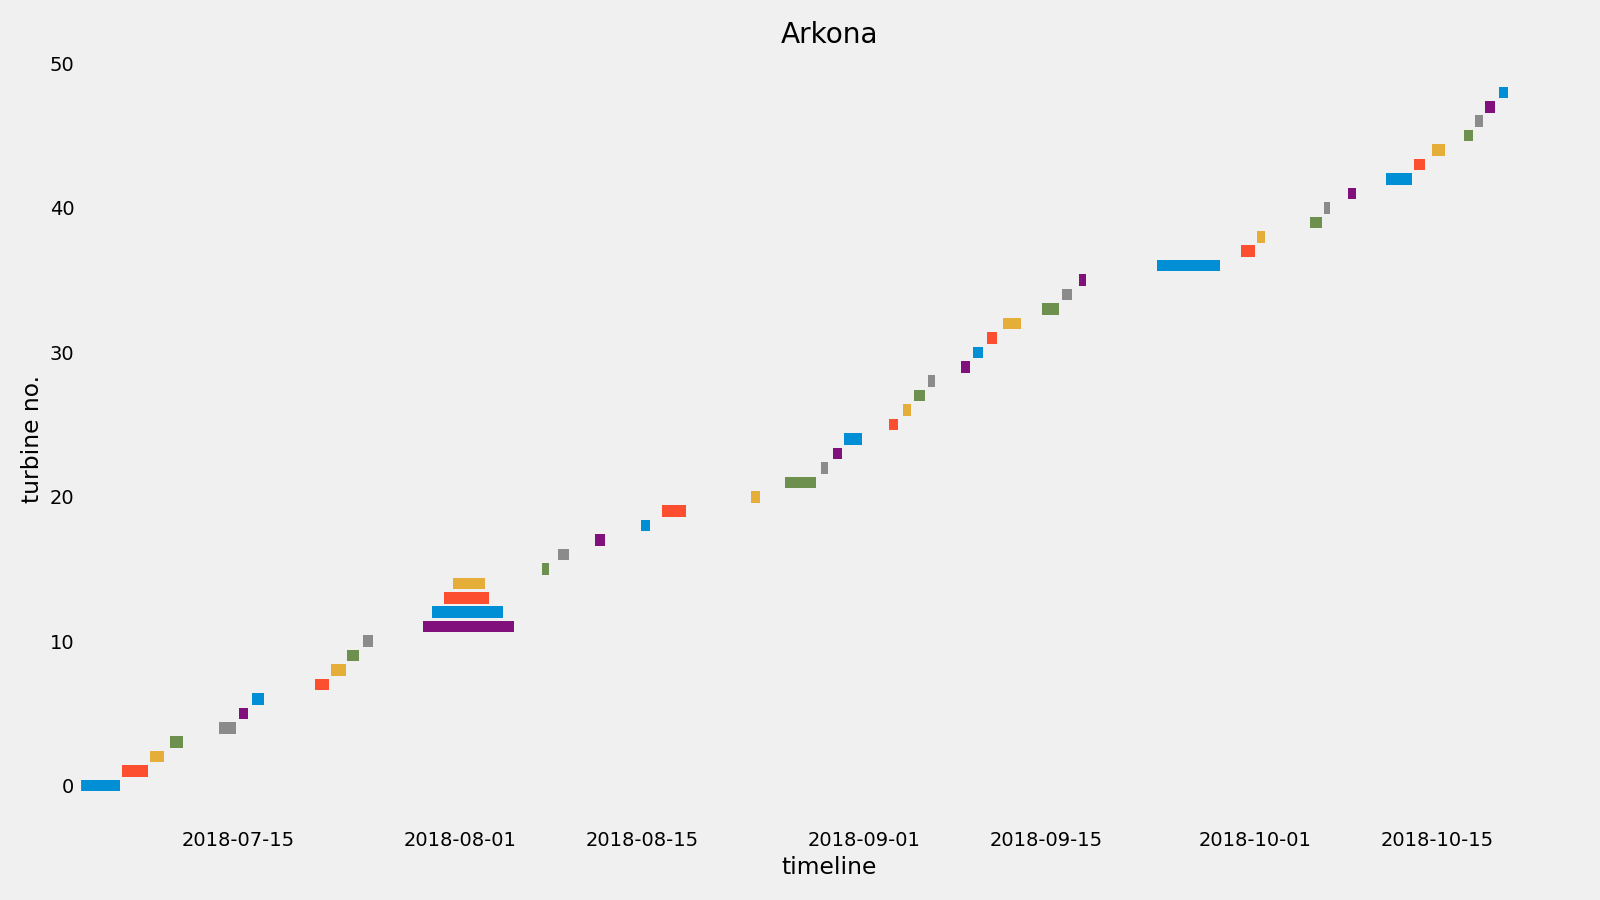

<IPython.core.display.Javascript object>


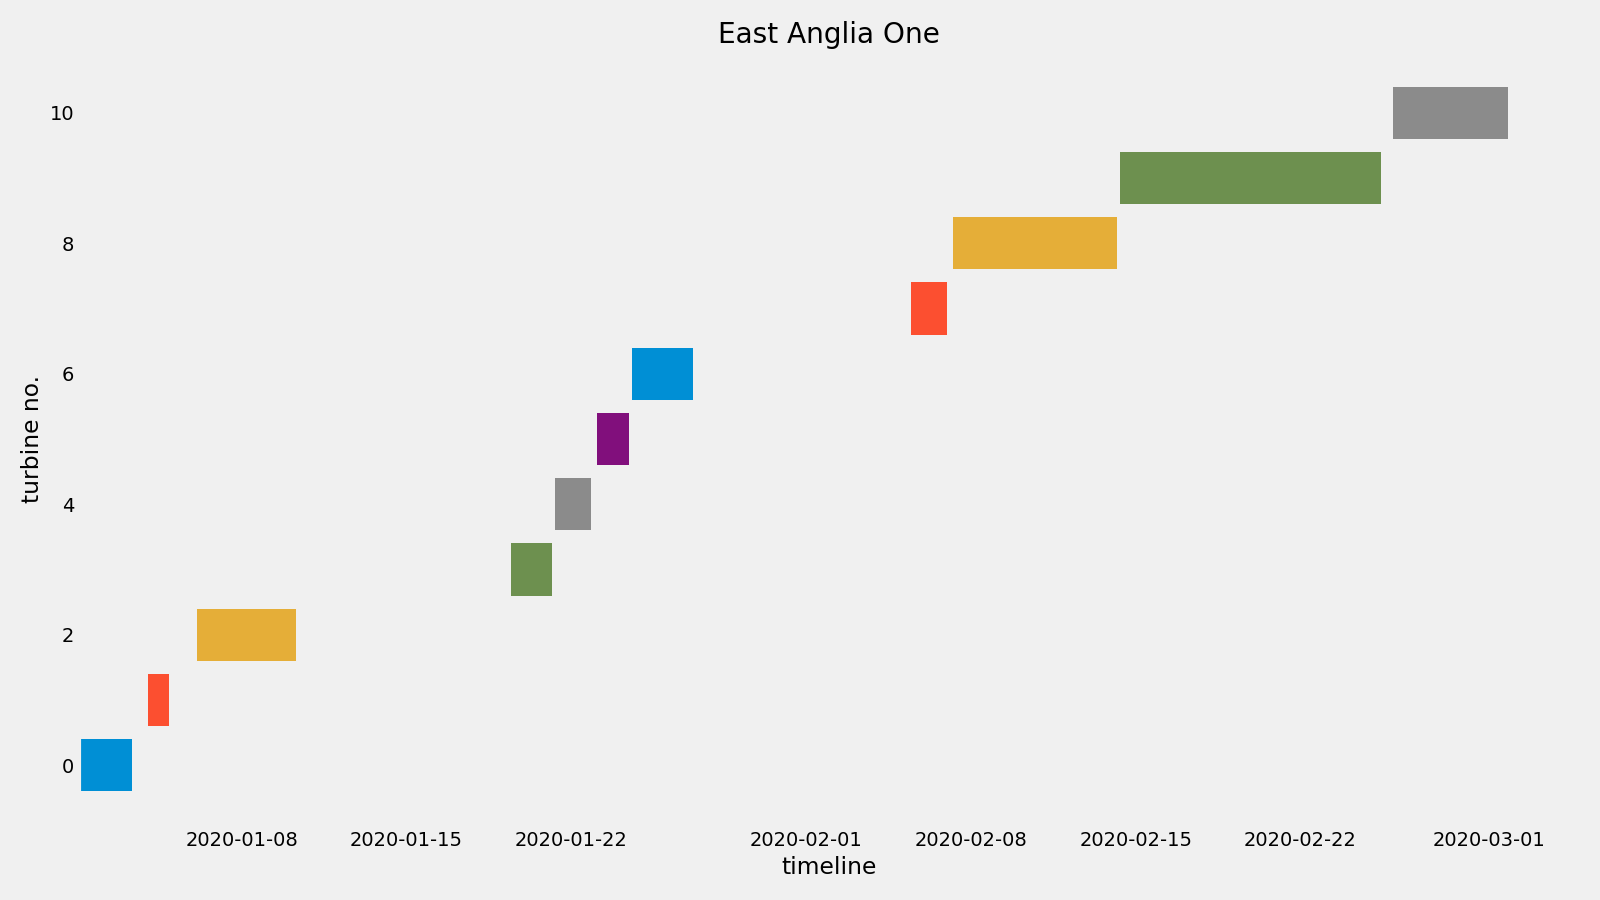

<IPython.core.display.Javascript object>


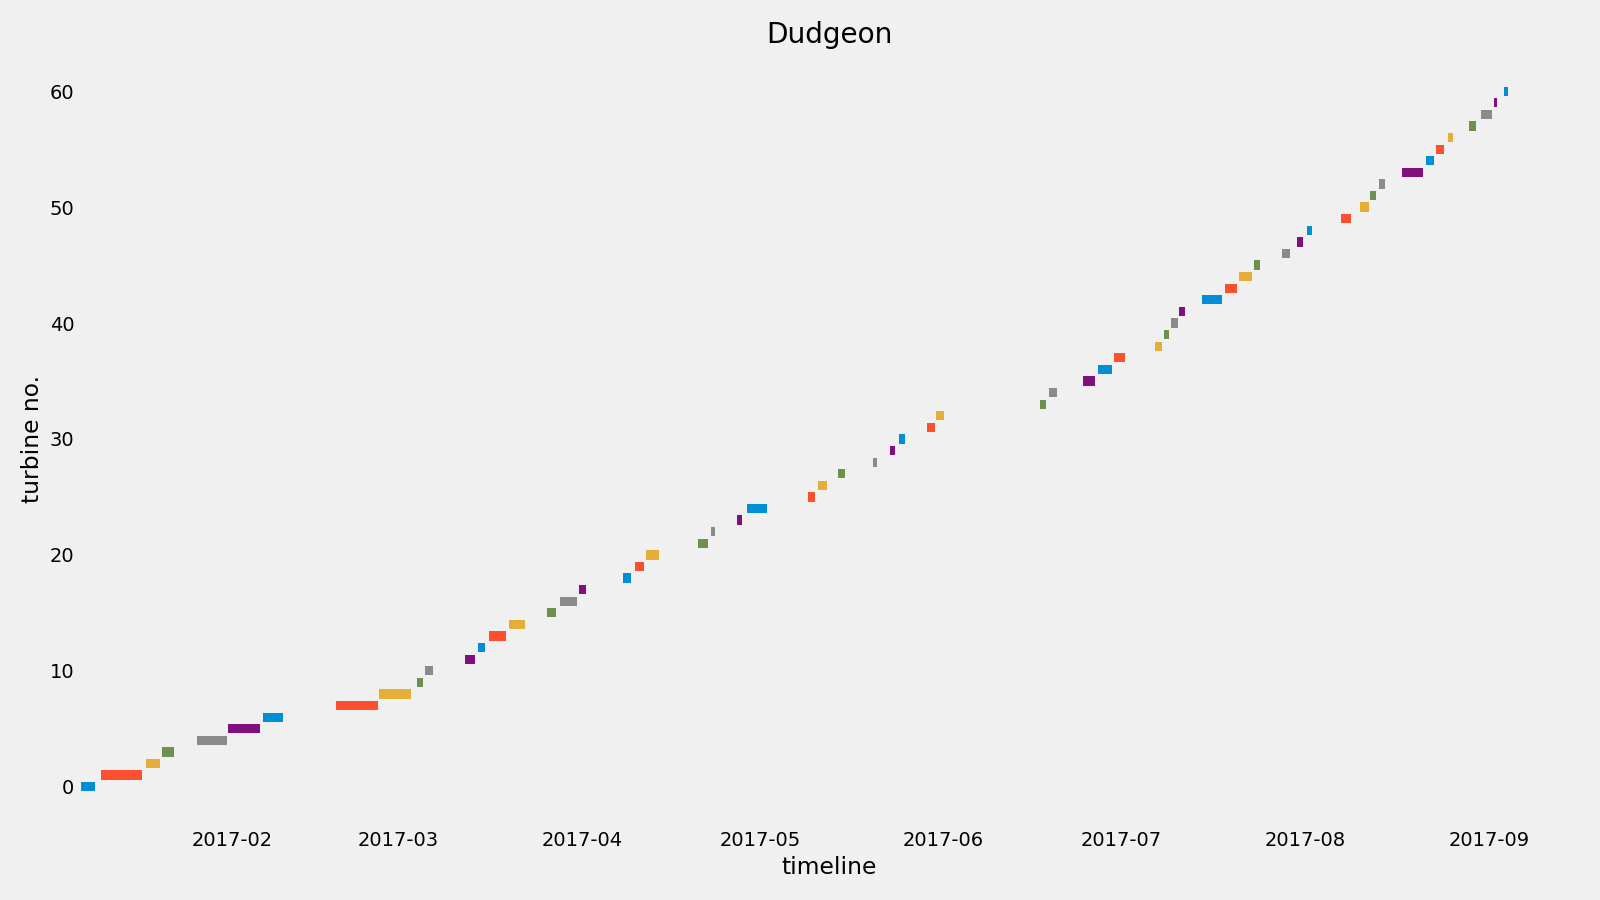

<IPython.core.display.Javascript object>


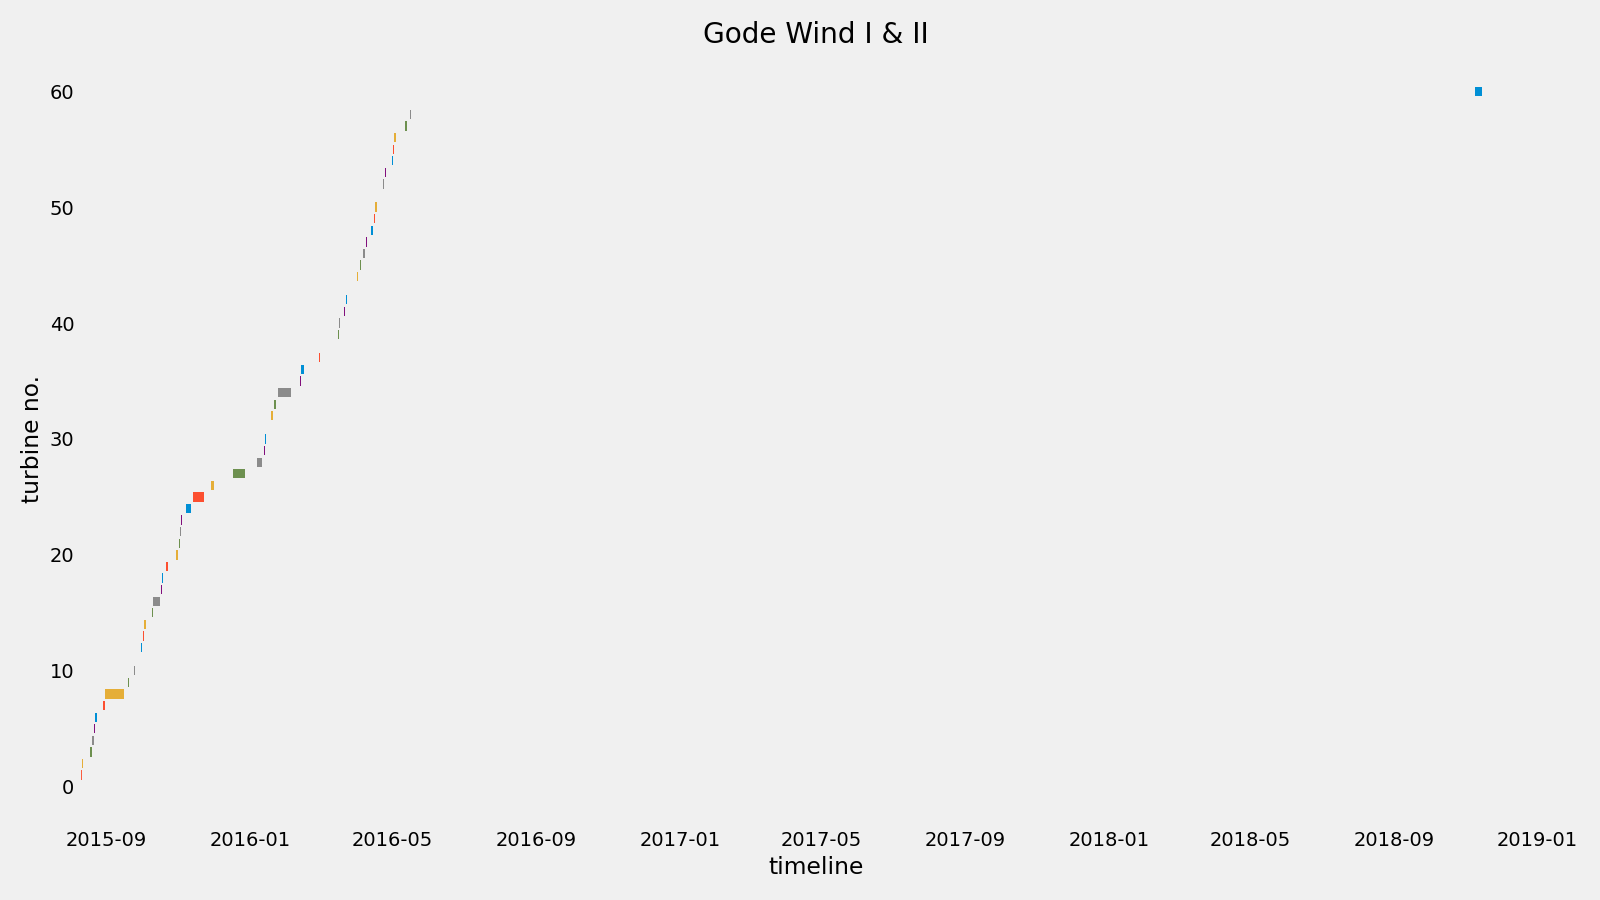

<IPython.core.display.Javascript object>


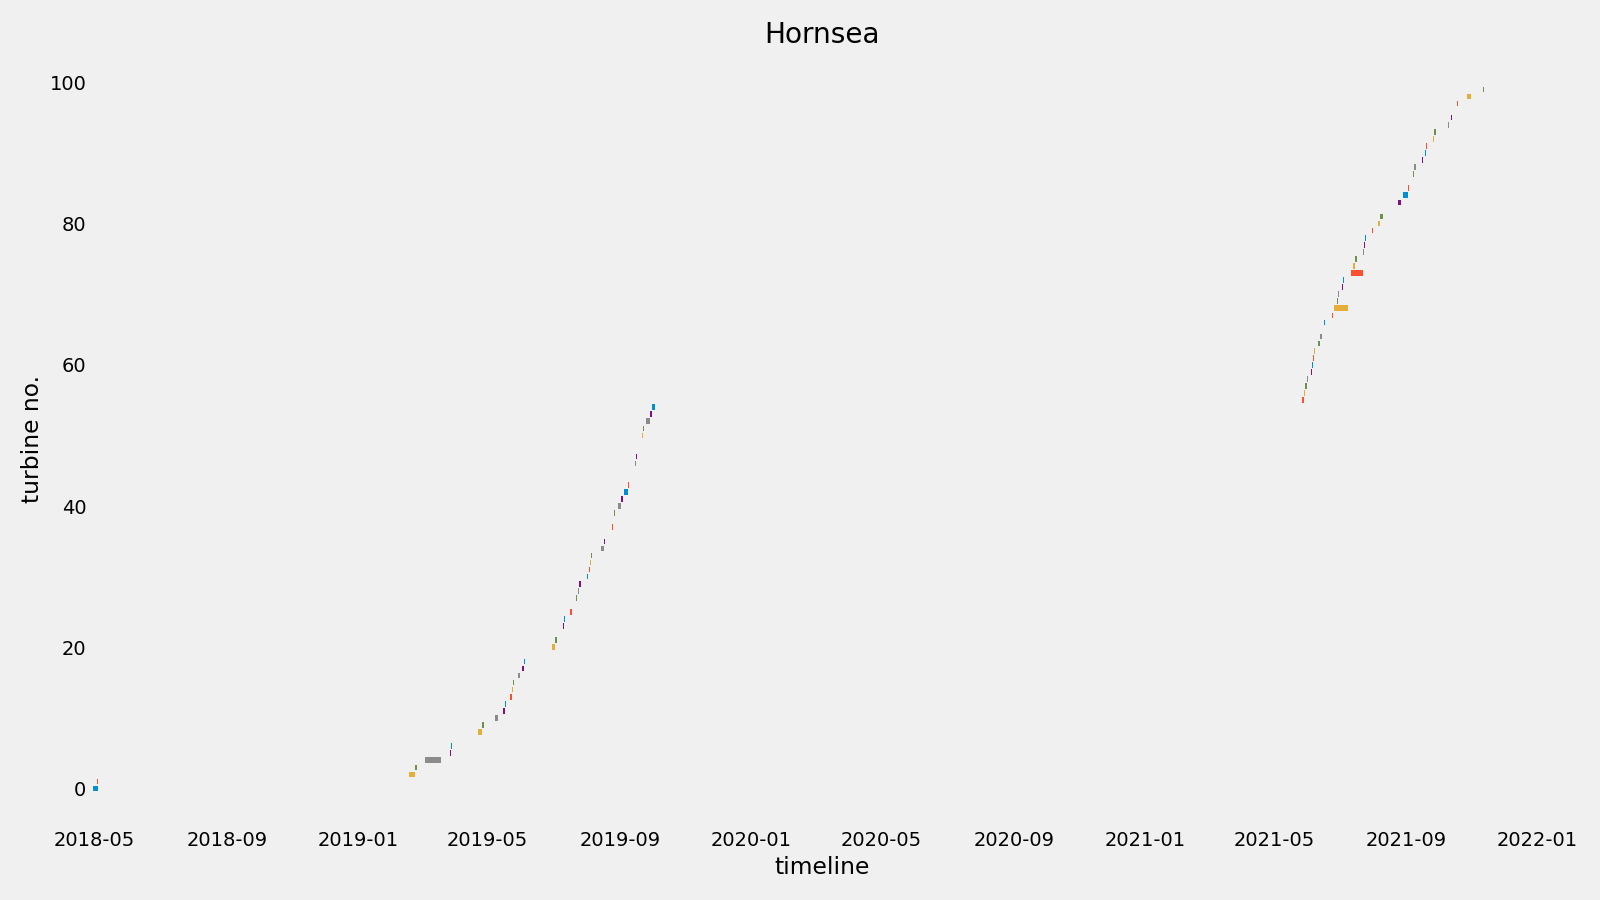

<IPython.core.display.Javascript object>


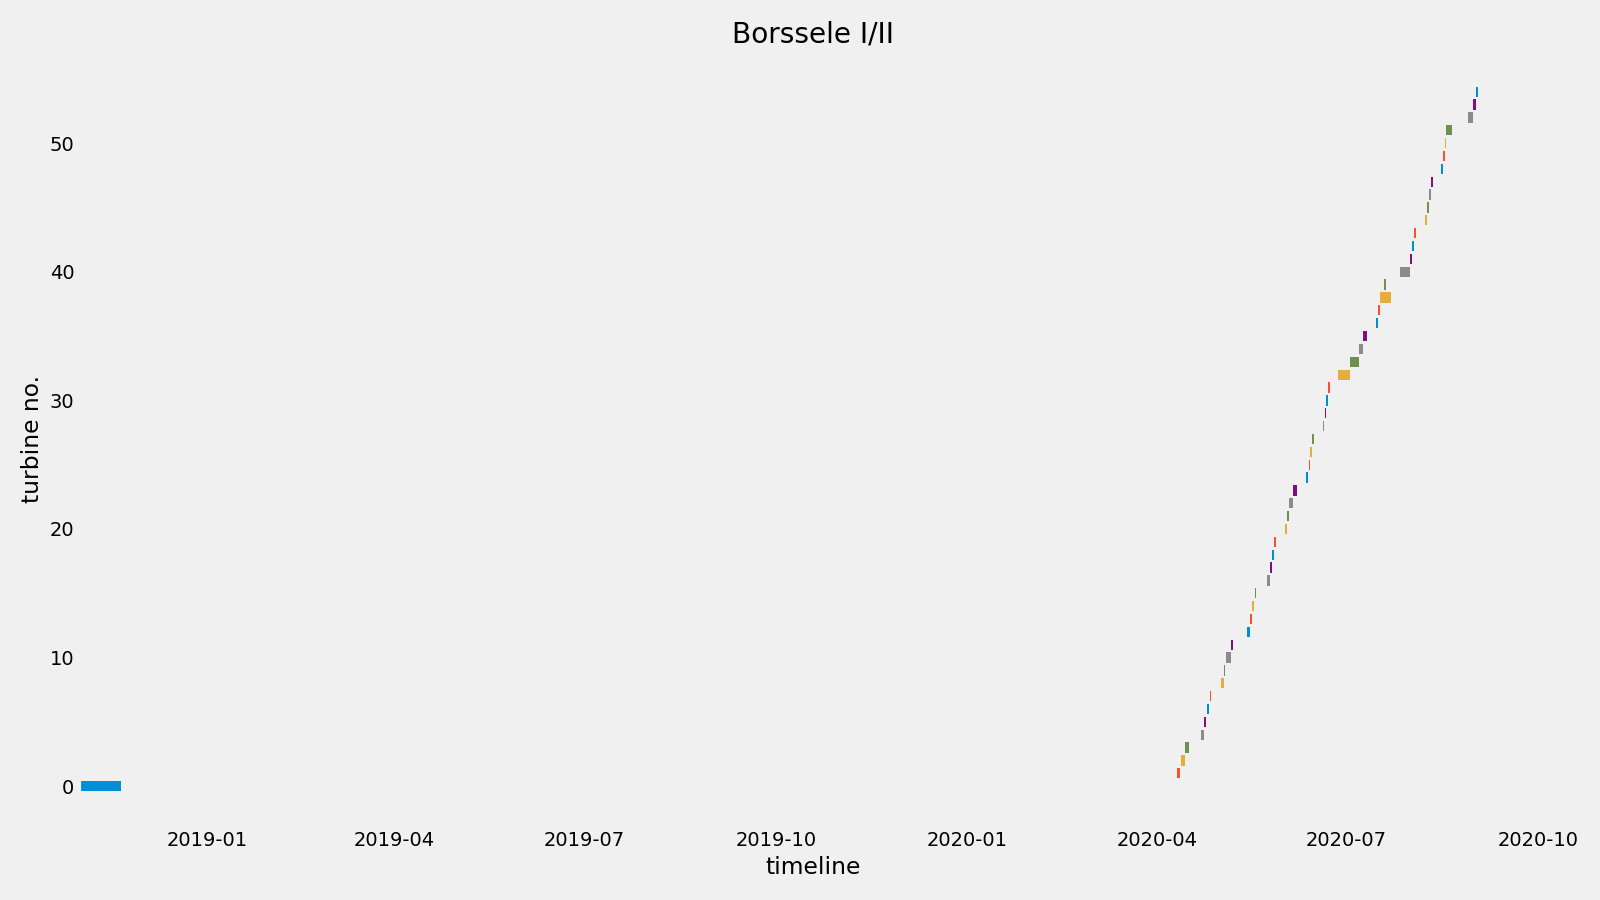

<IPython.core.display.Javascript object>


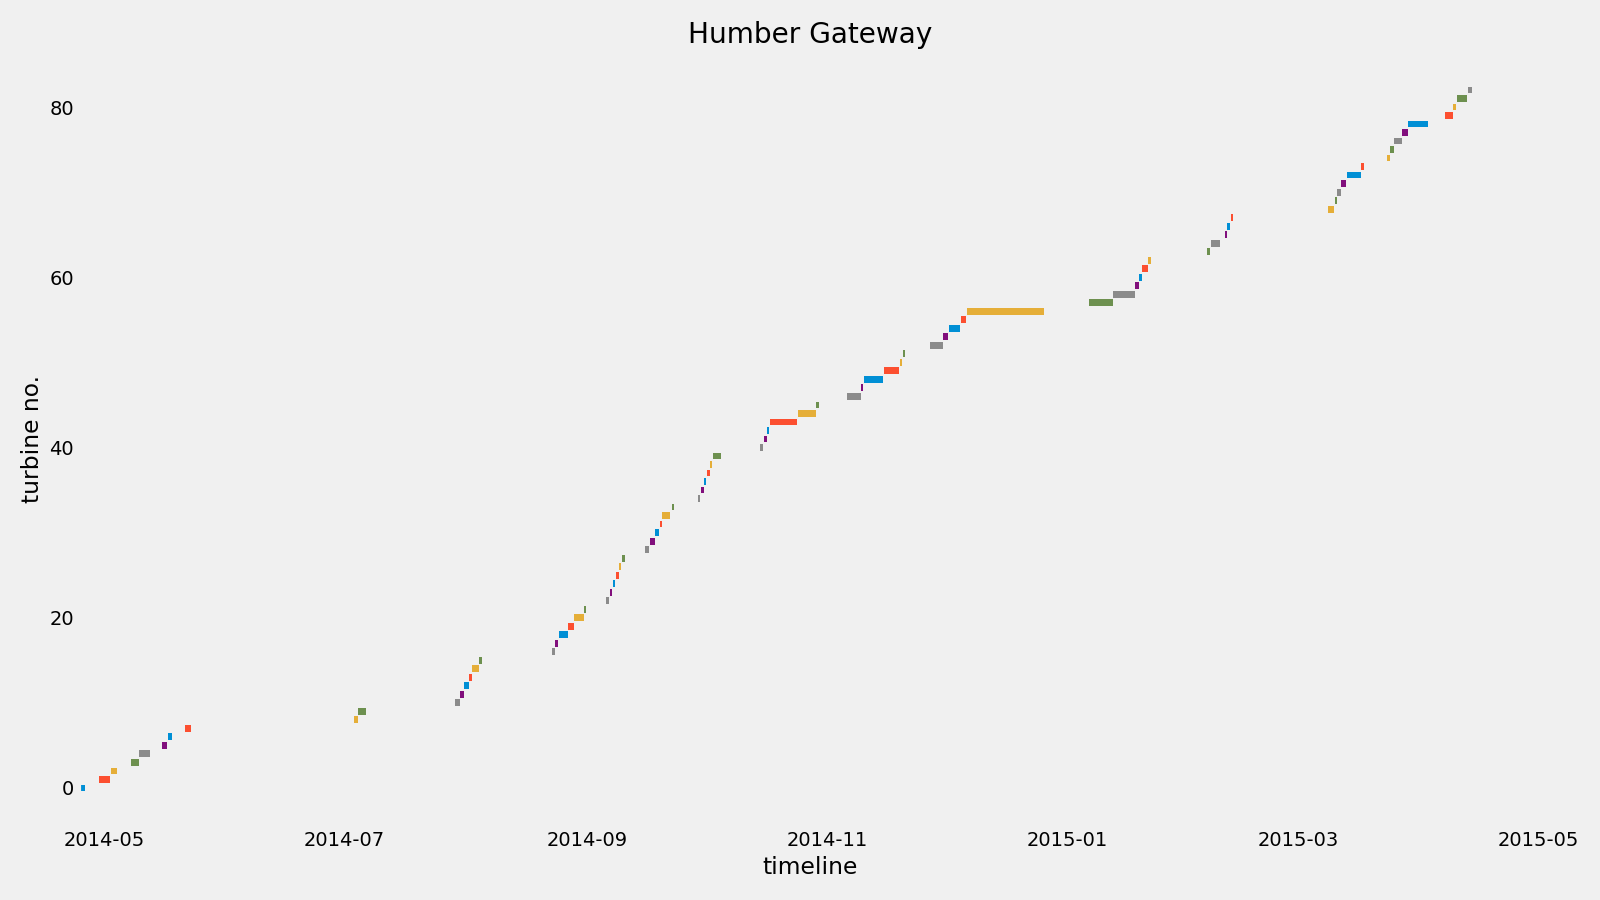

<IPython.core.display.Javascript object>


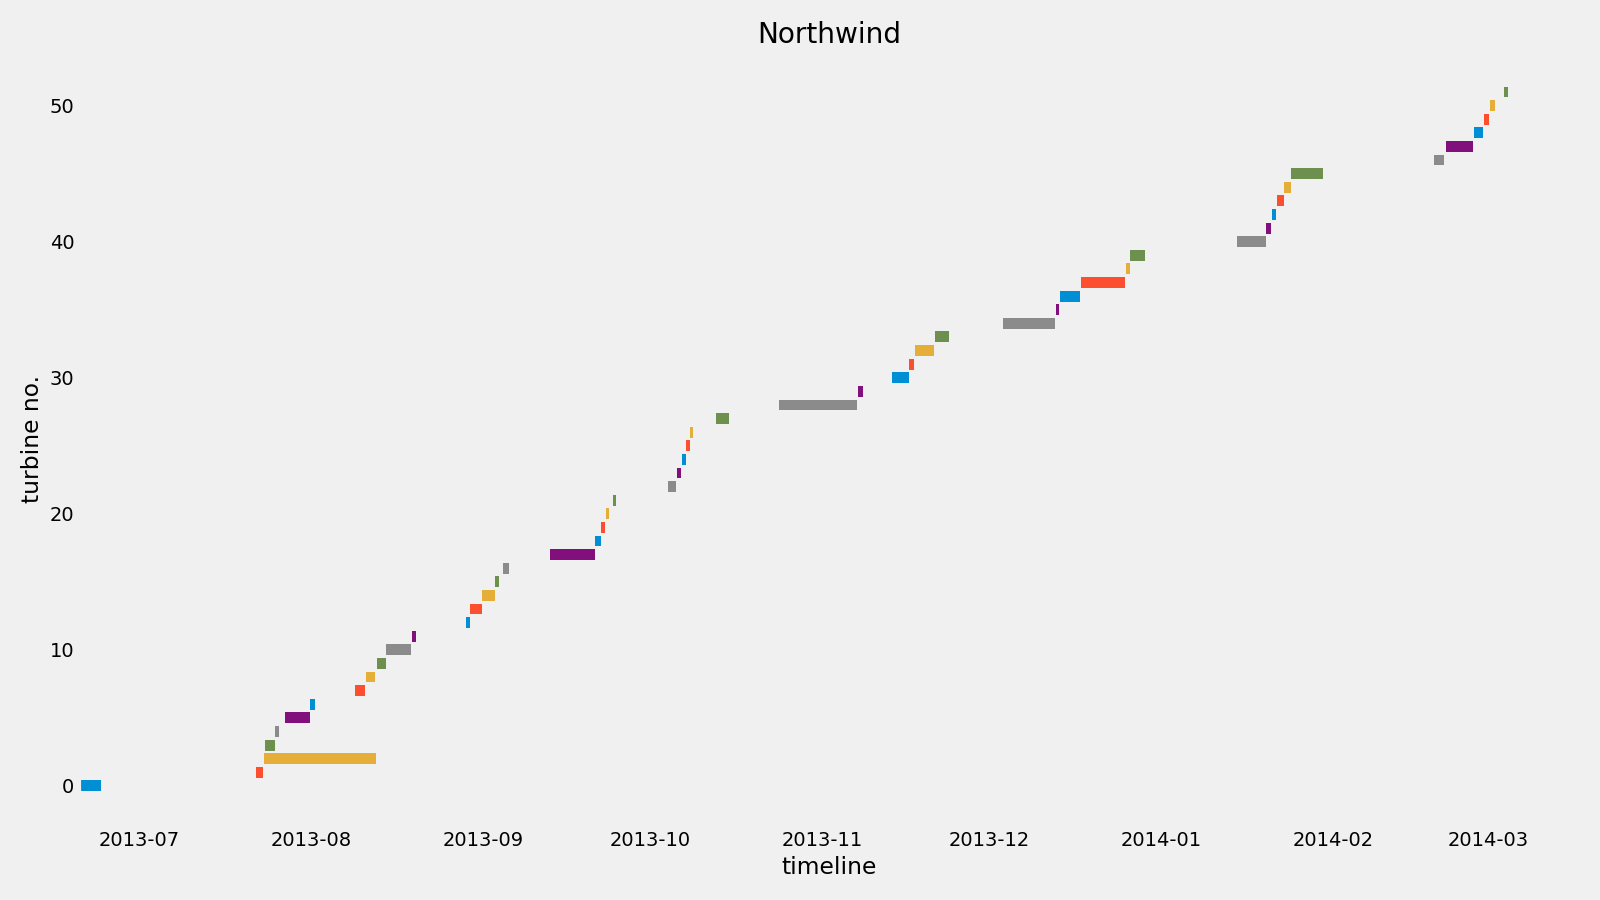

<IPython.core.display.Javascript object>


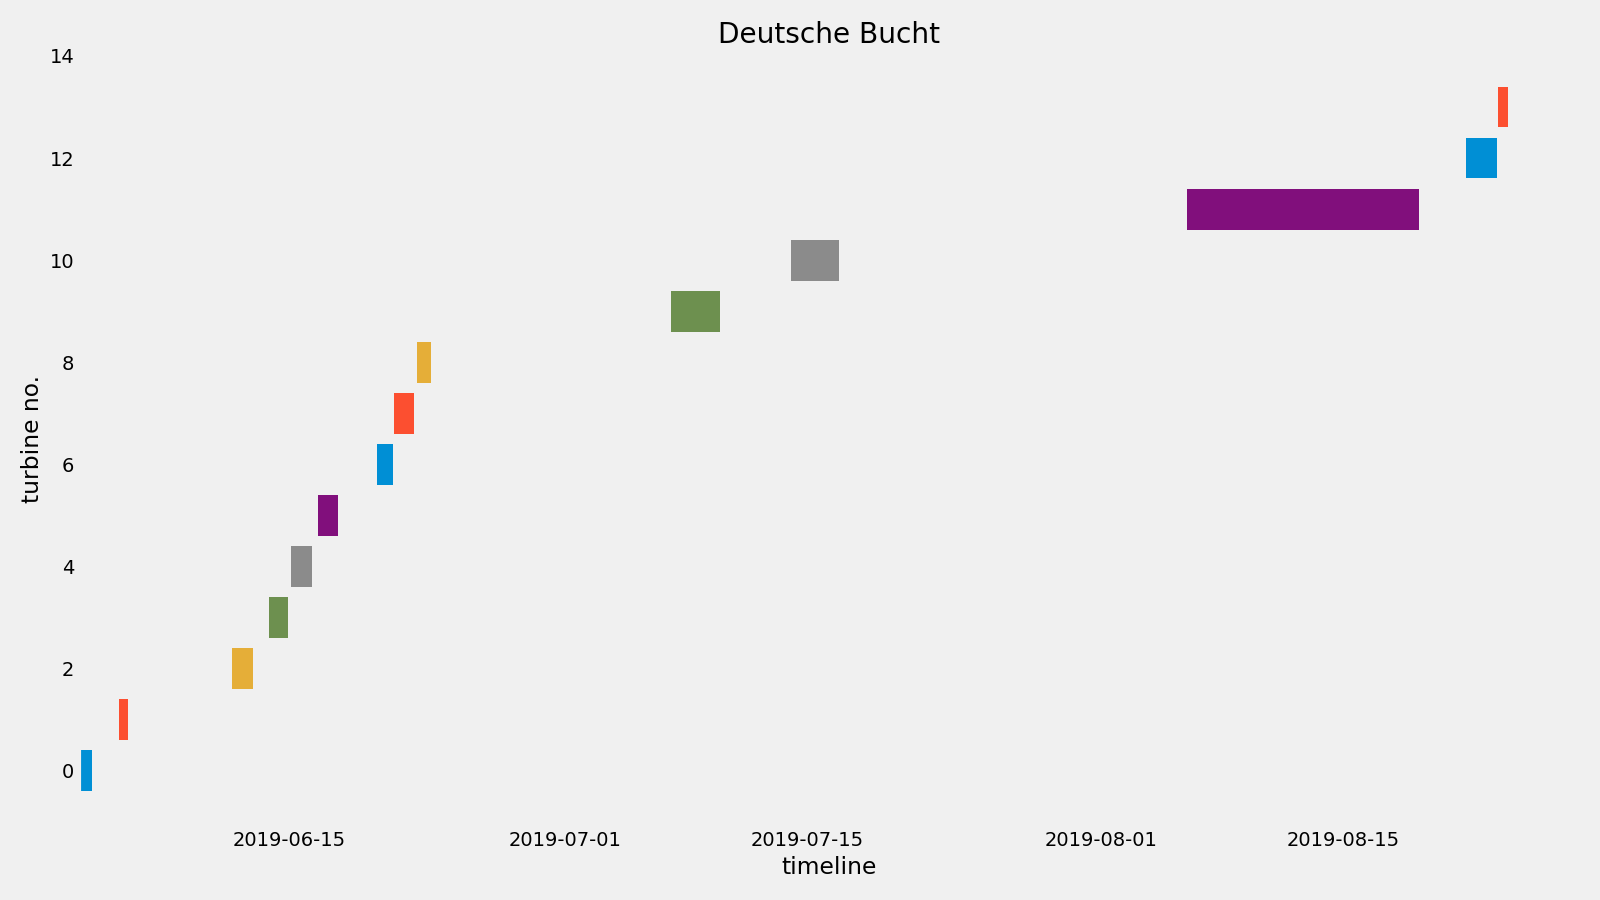

<IPython.core.display.Javascript object>


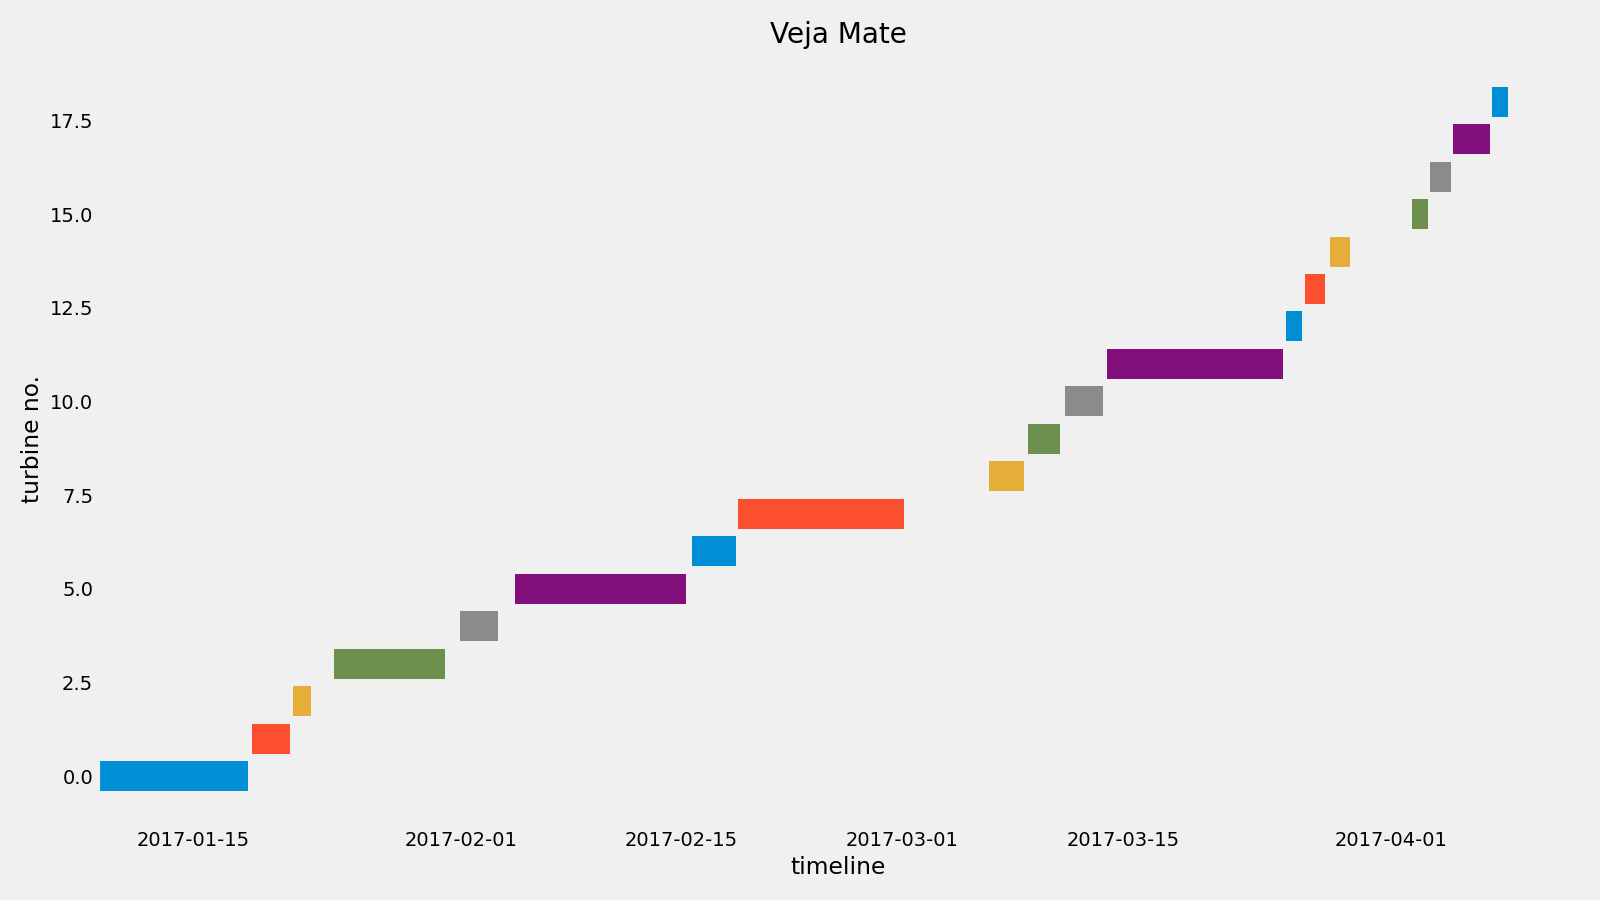

<IPython.core.display.Javascript object>


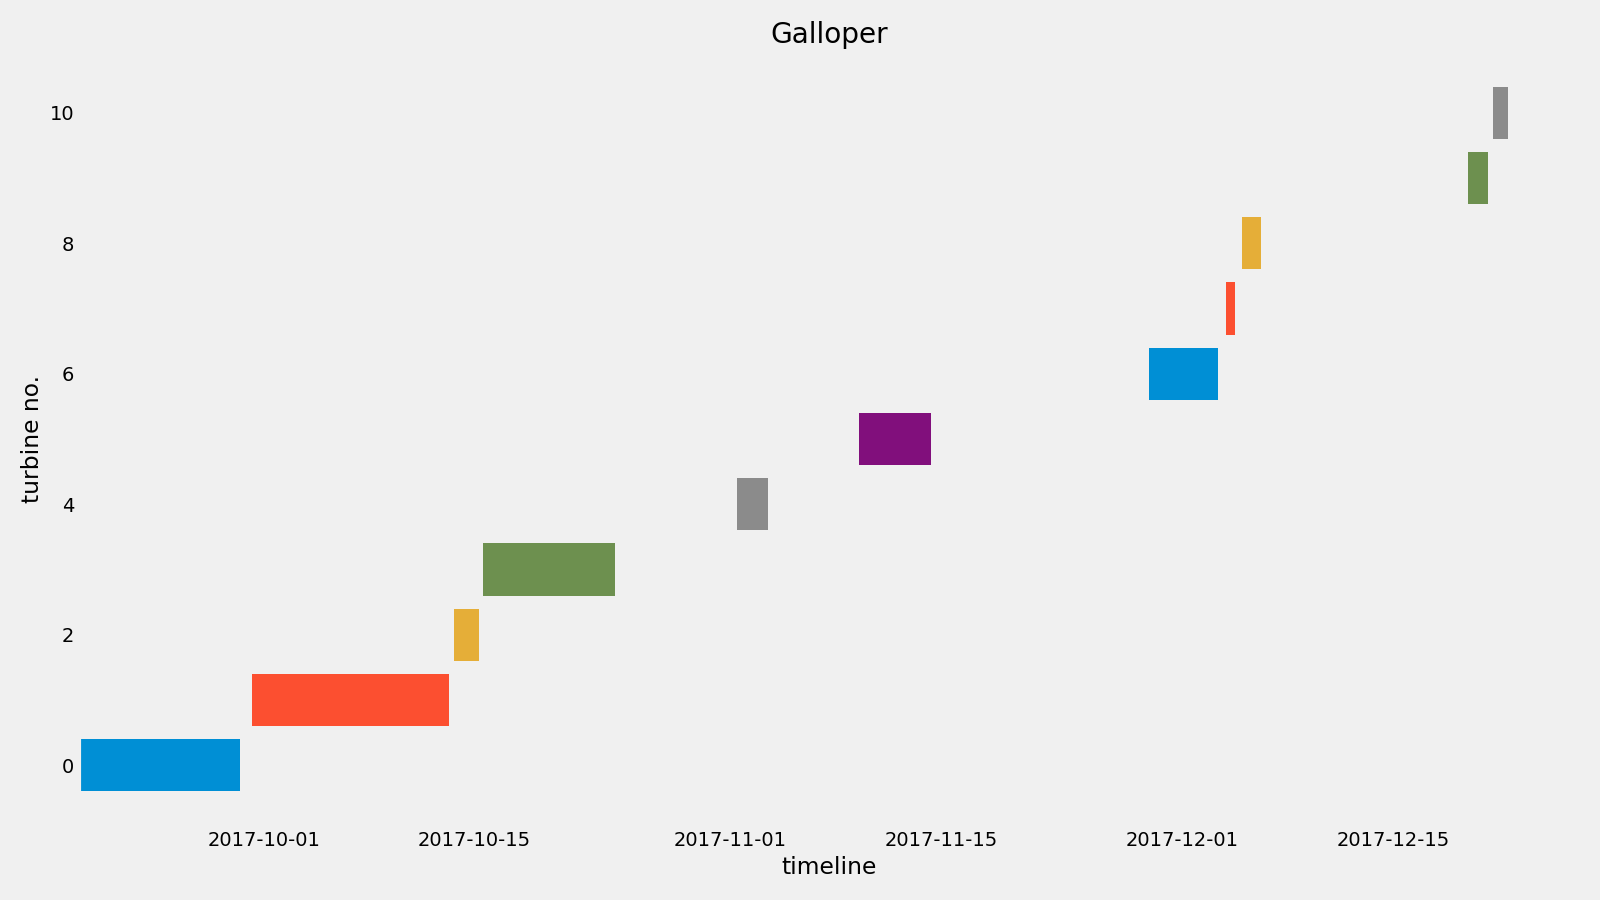

<IPython.core.display.Javascript object>


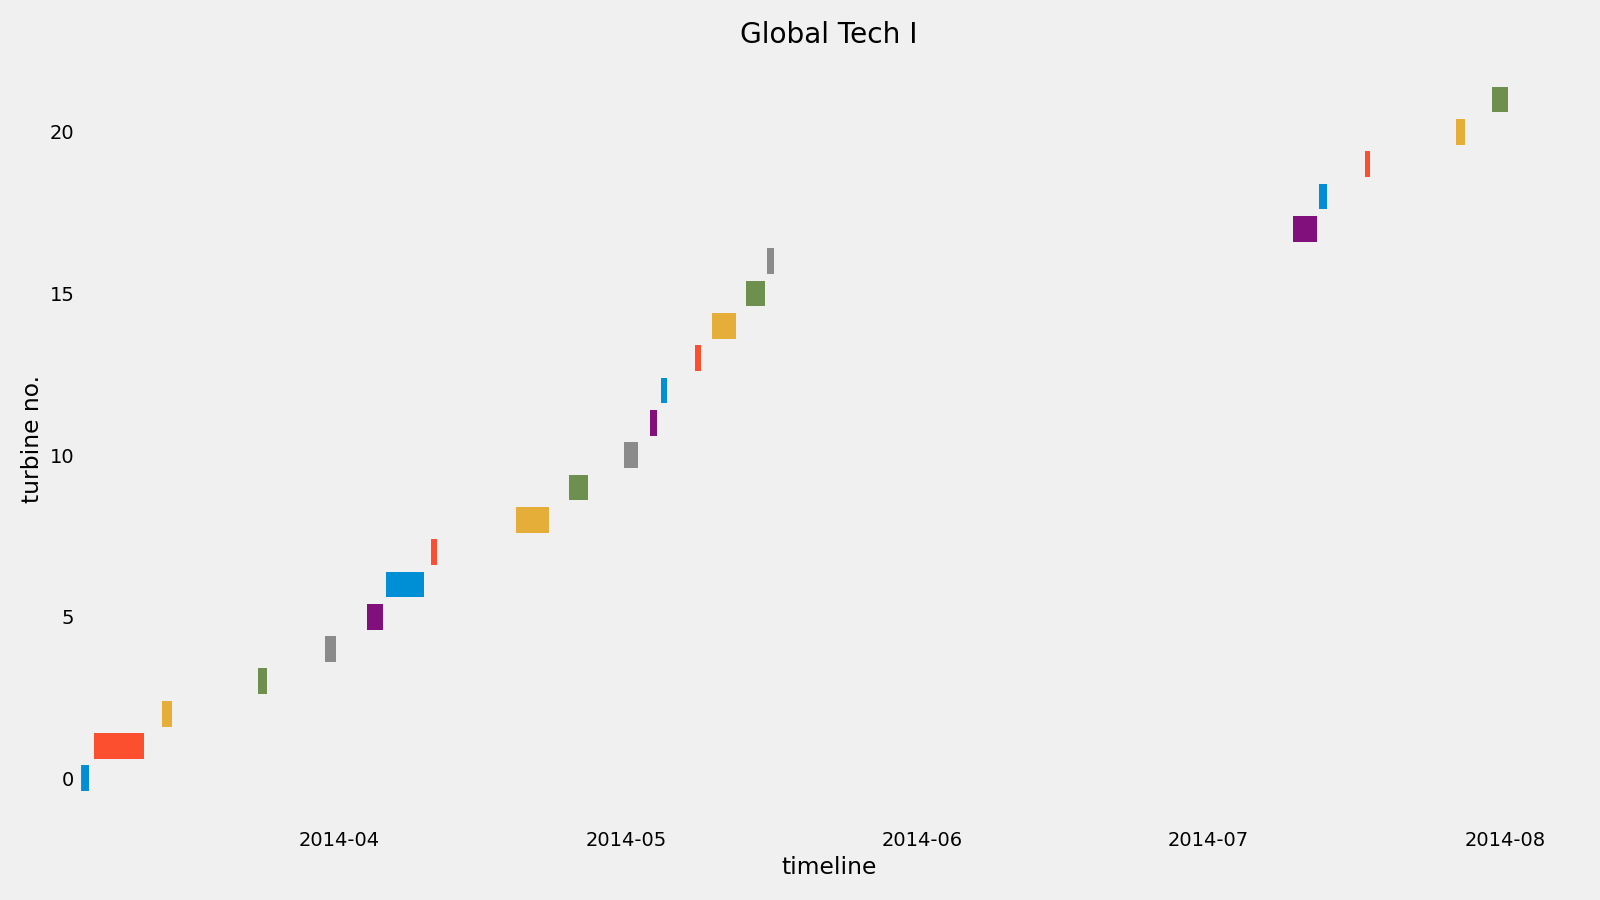

<IPython.core.display.Javascript object>


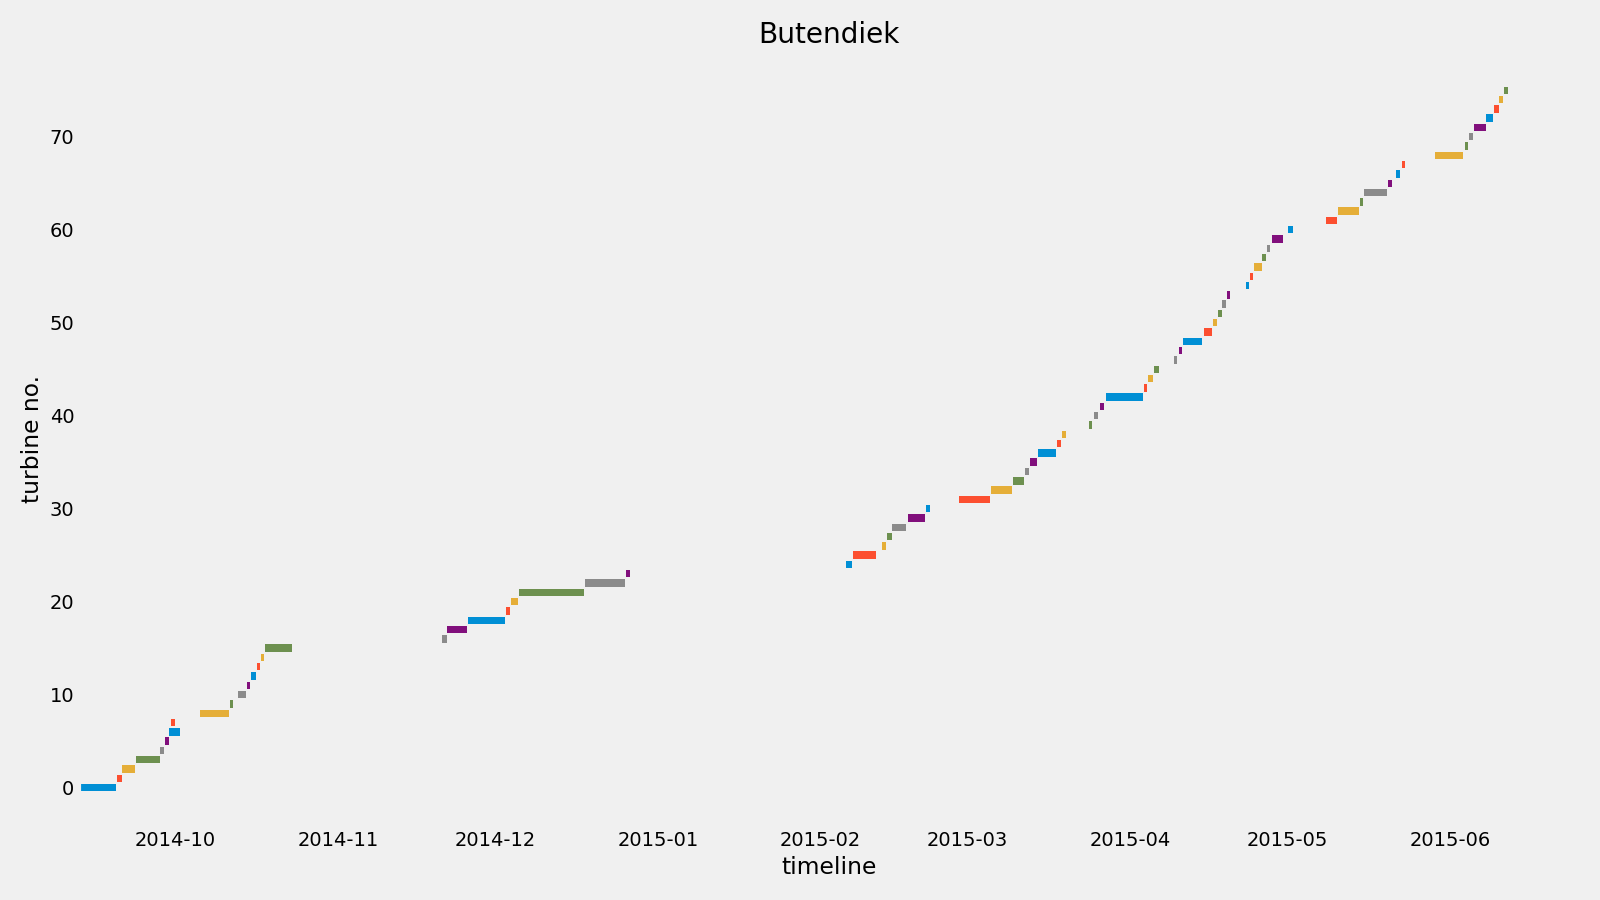

/home/san/Projects/PhD/publications/2022_WES_offshore-wind-installation/notebooks/../src/installations/plot.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


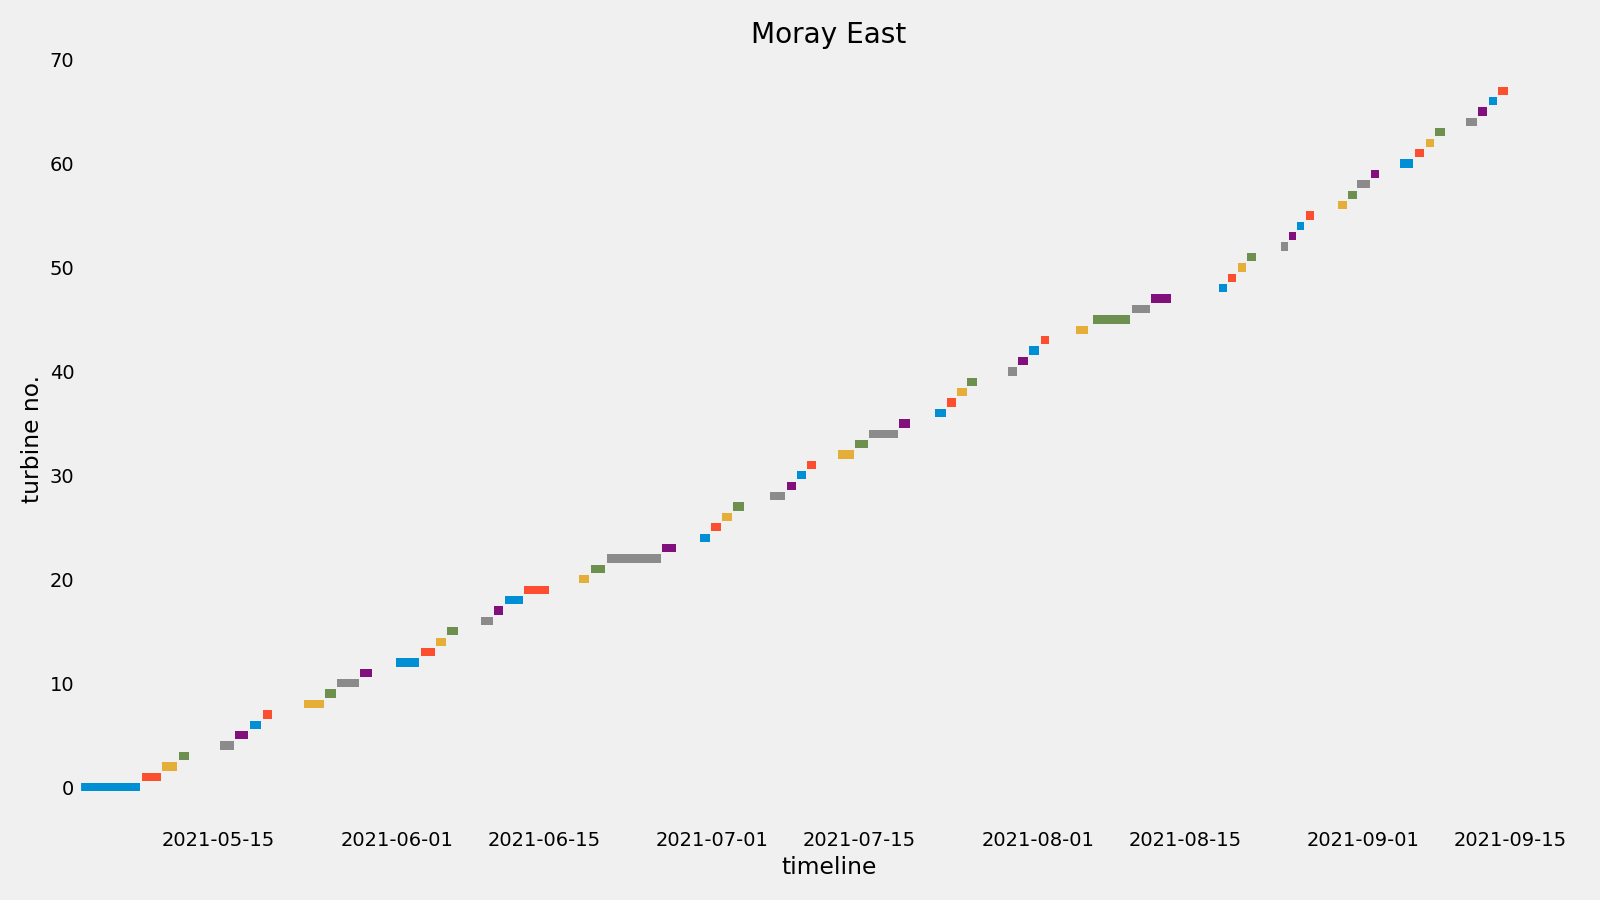

<IPython.core.display.Javascript object>


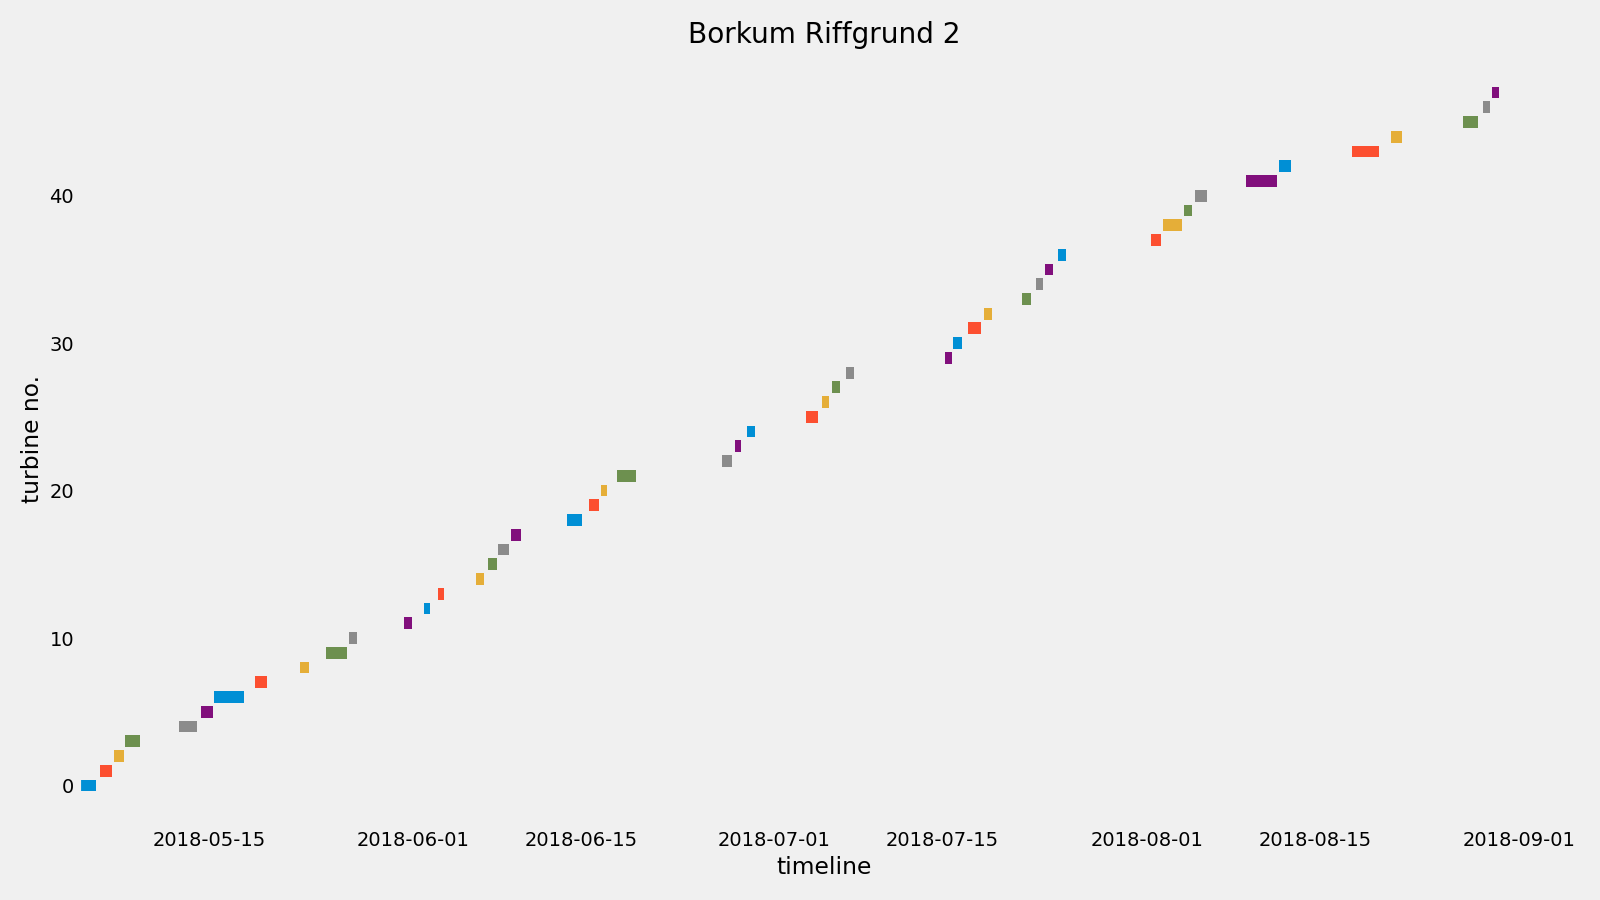

<IPython.core.display.Javascript object>


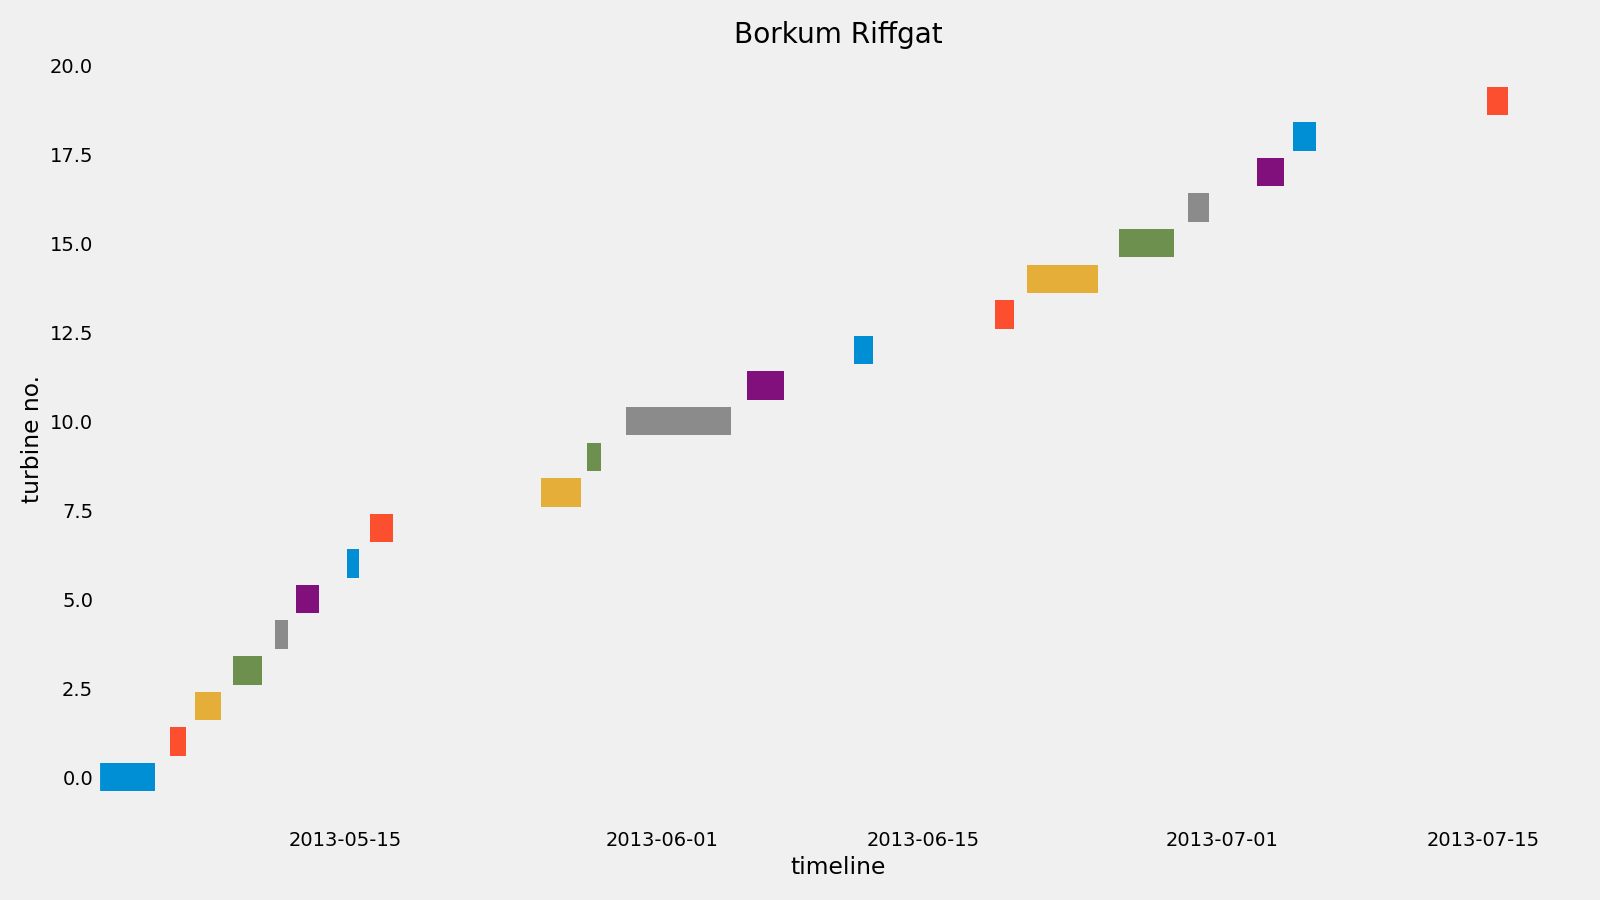

<IPython.core.display.Javascript object>


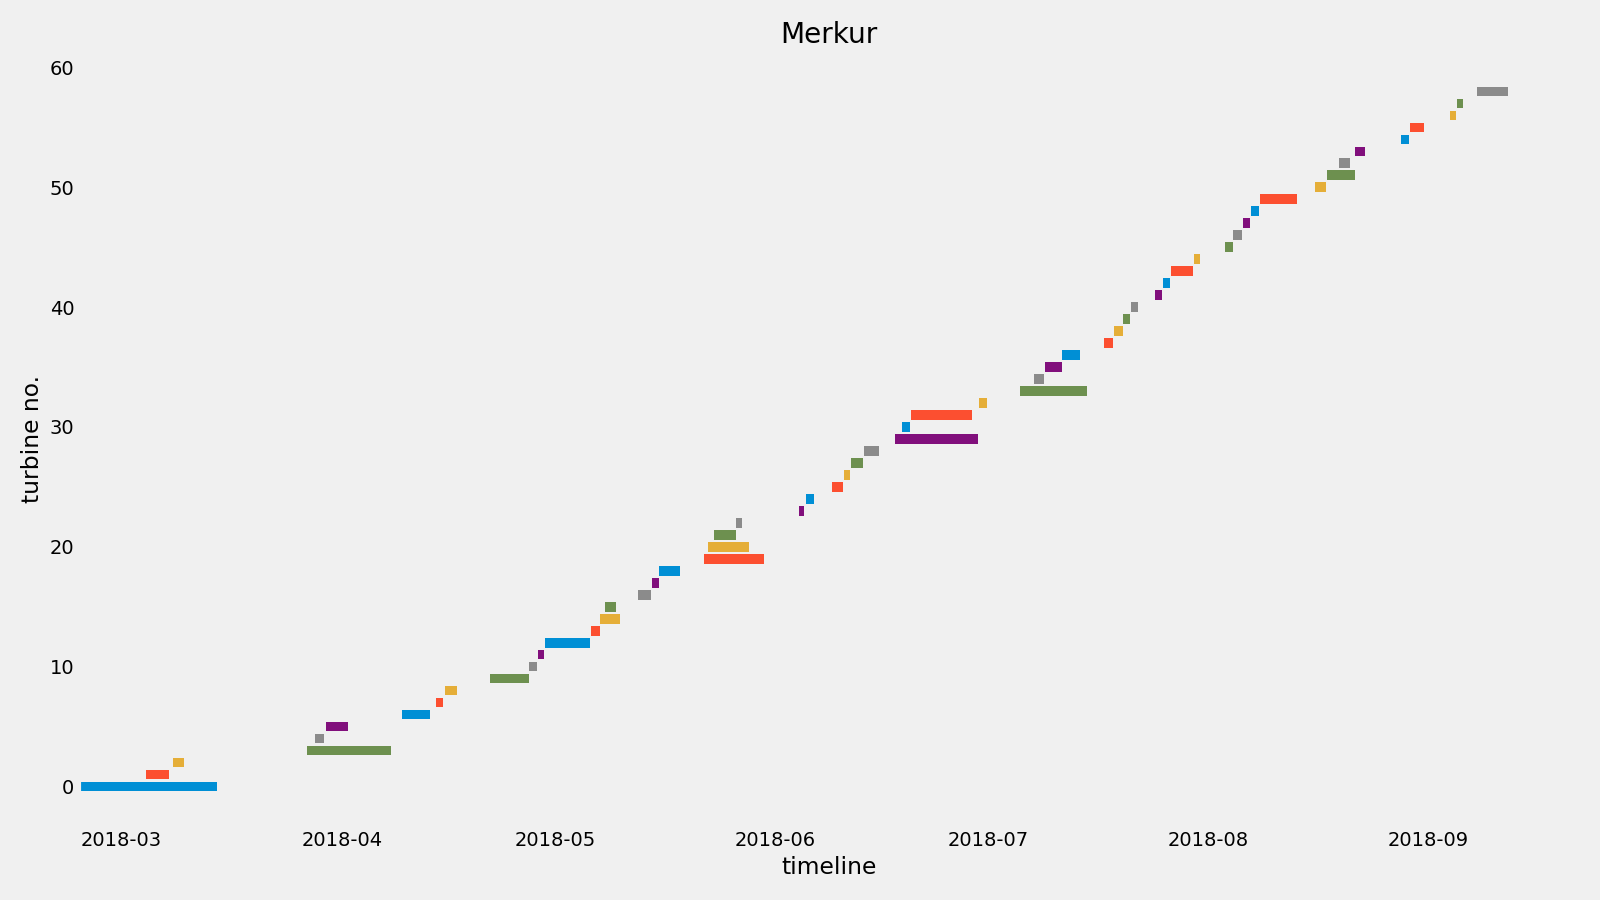

<IPython.core.display.Javascript object>


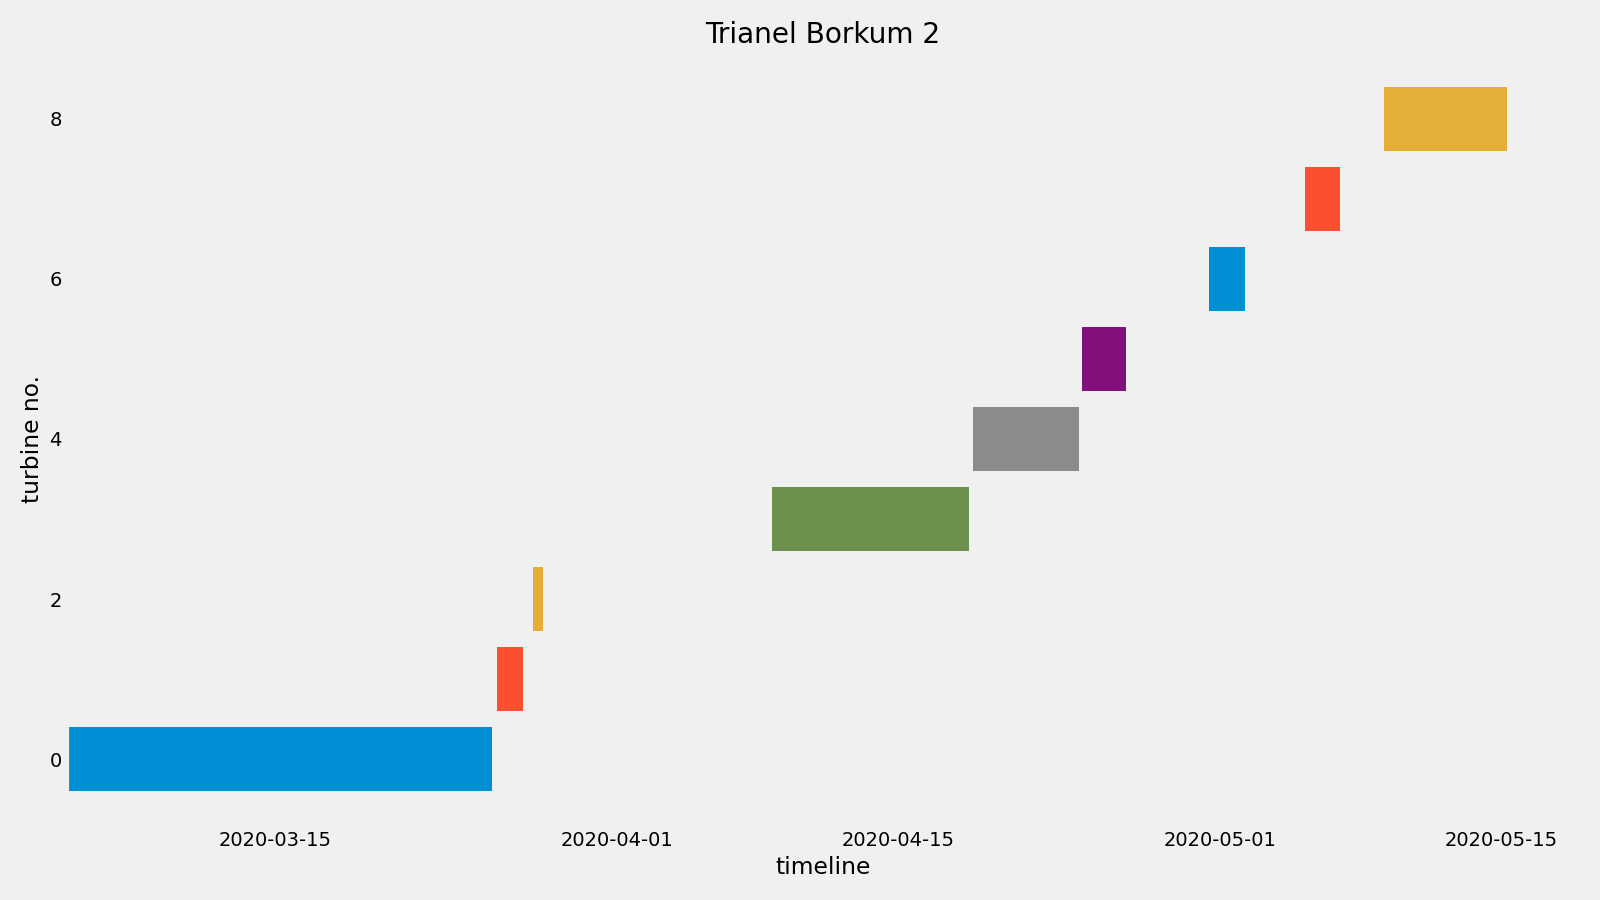

<IPython.core.display.Javascript object>


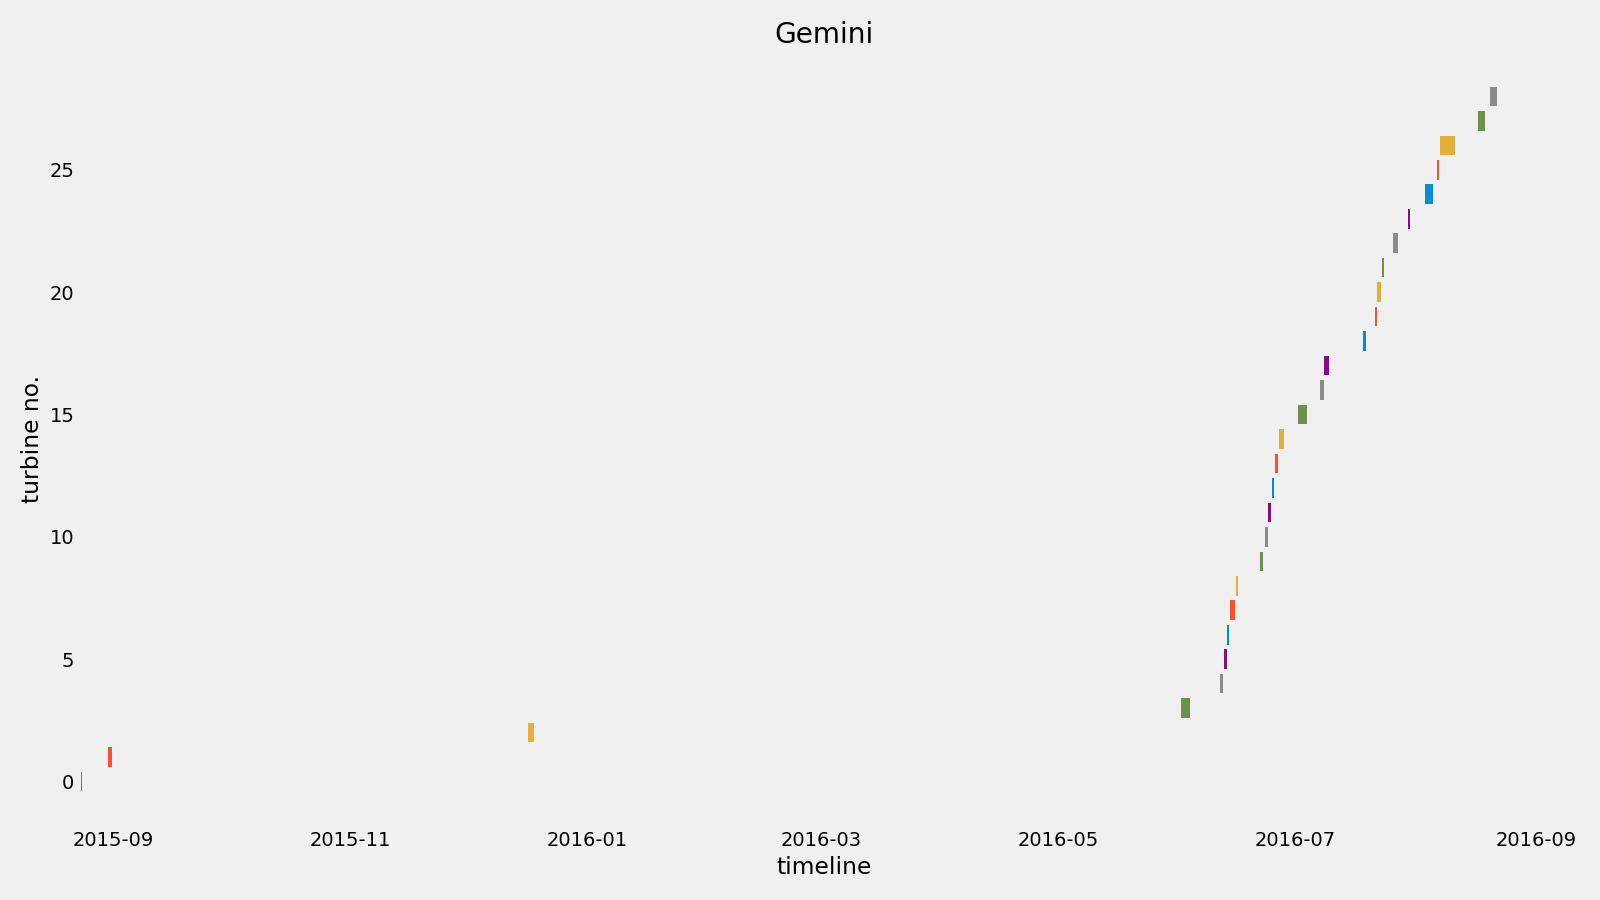

<IPython.core.display.Javascript object>


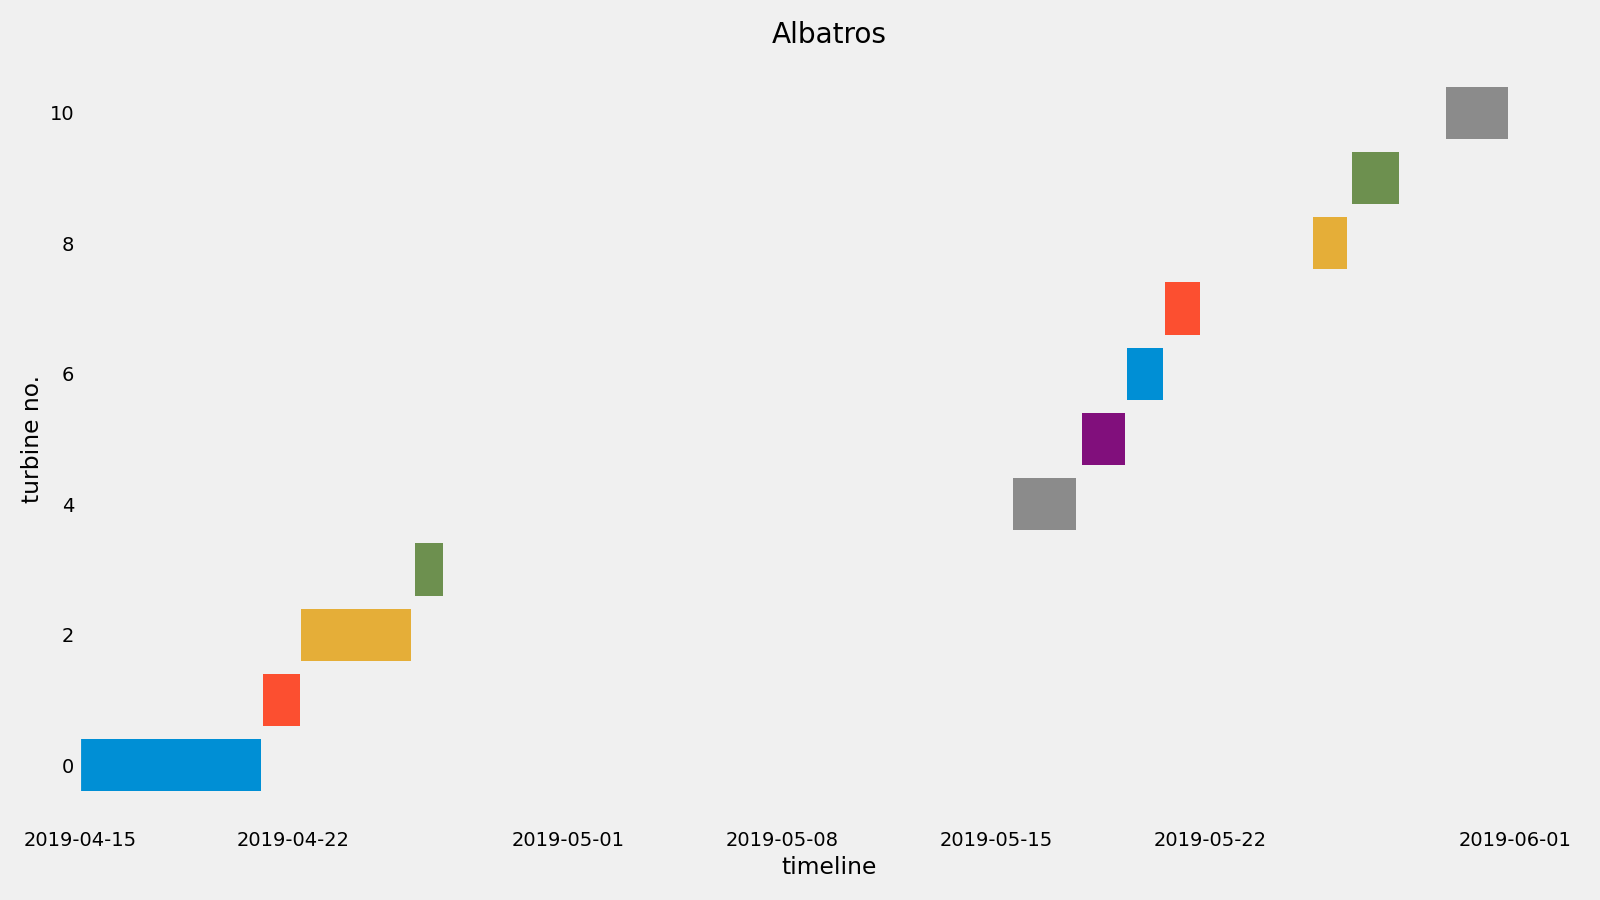

<IPython.core.display.Javascript object>


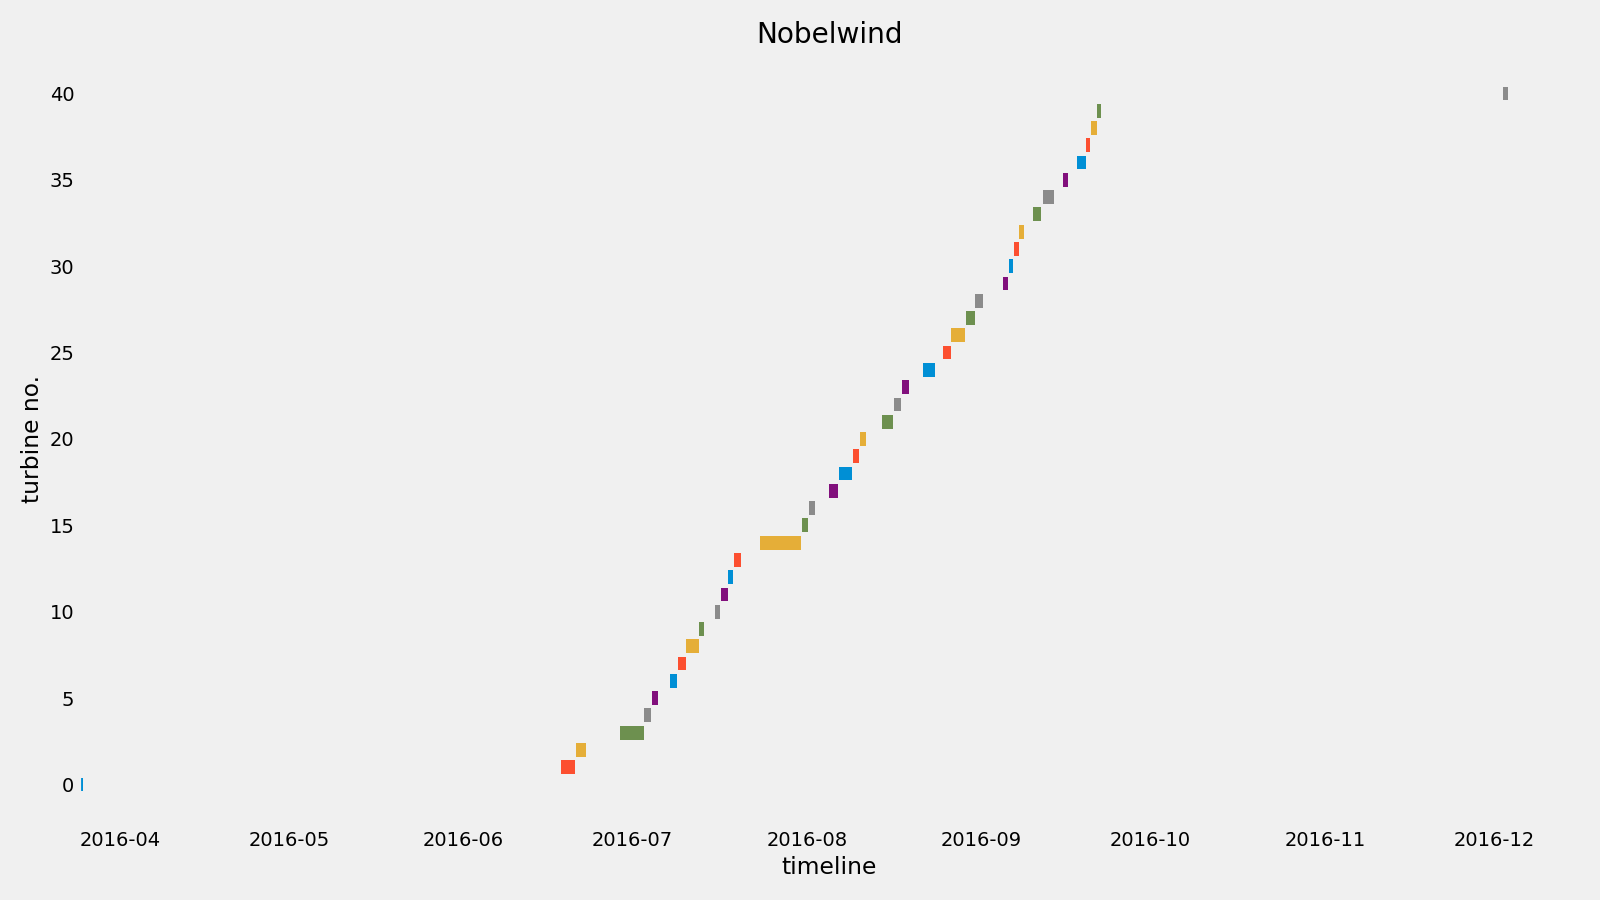

<IPython.core.display.Javascript object>


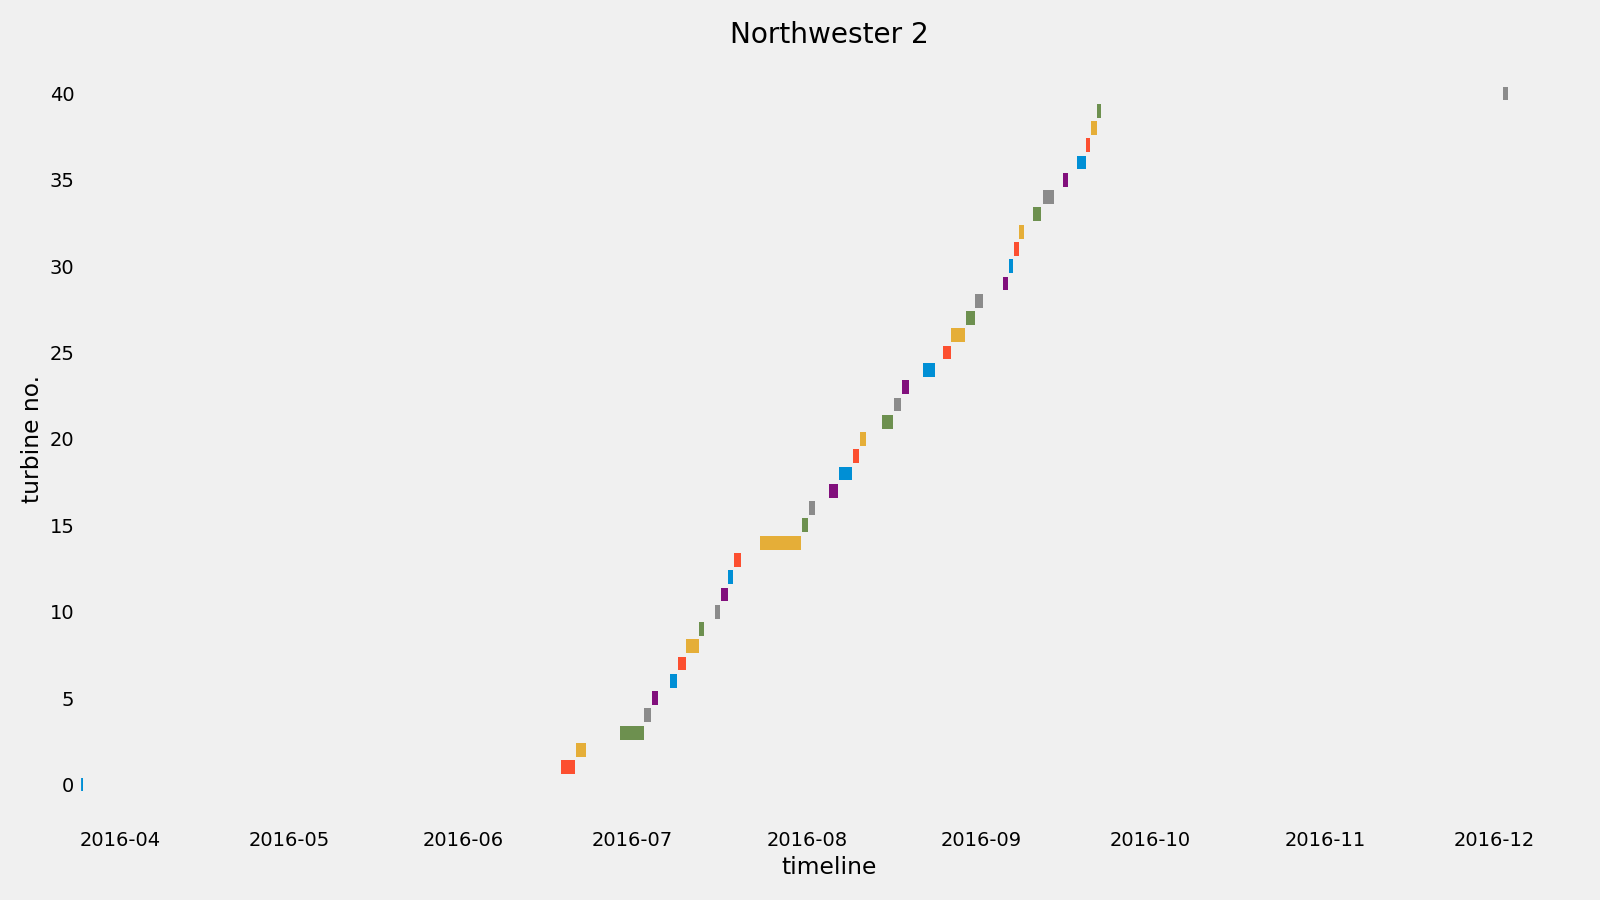

<IPython.core.display.Javascript object>


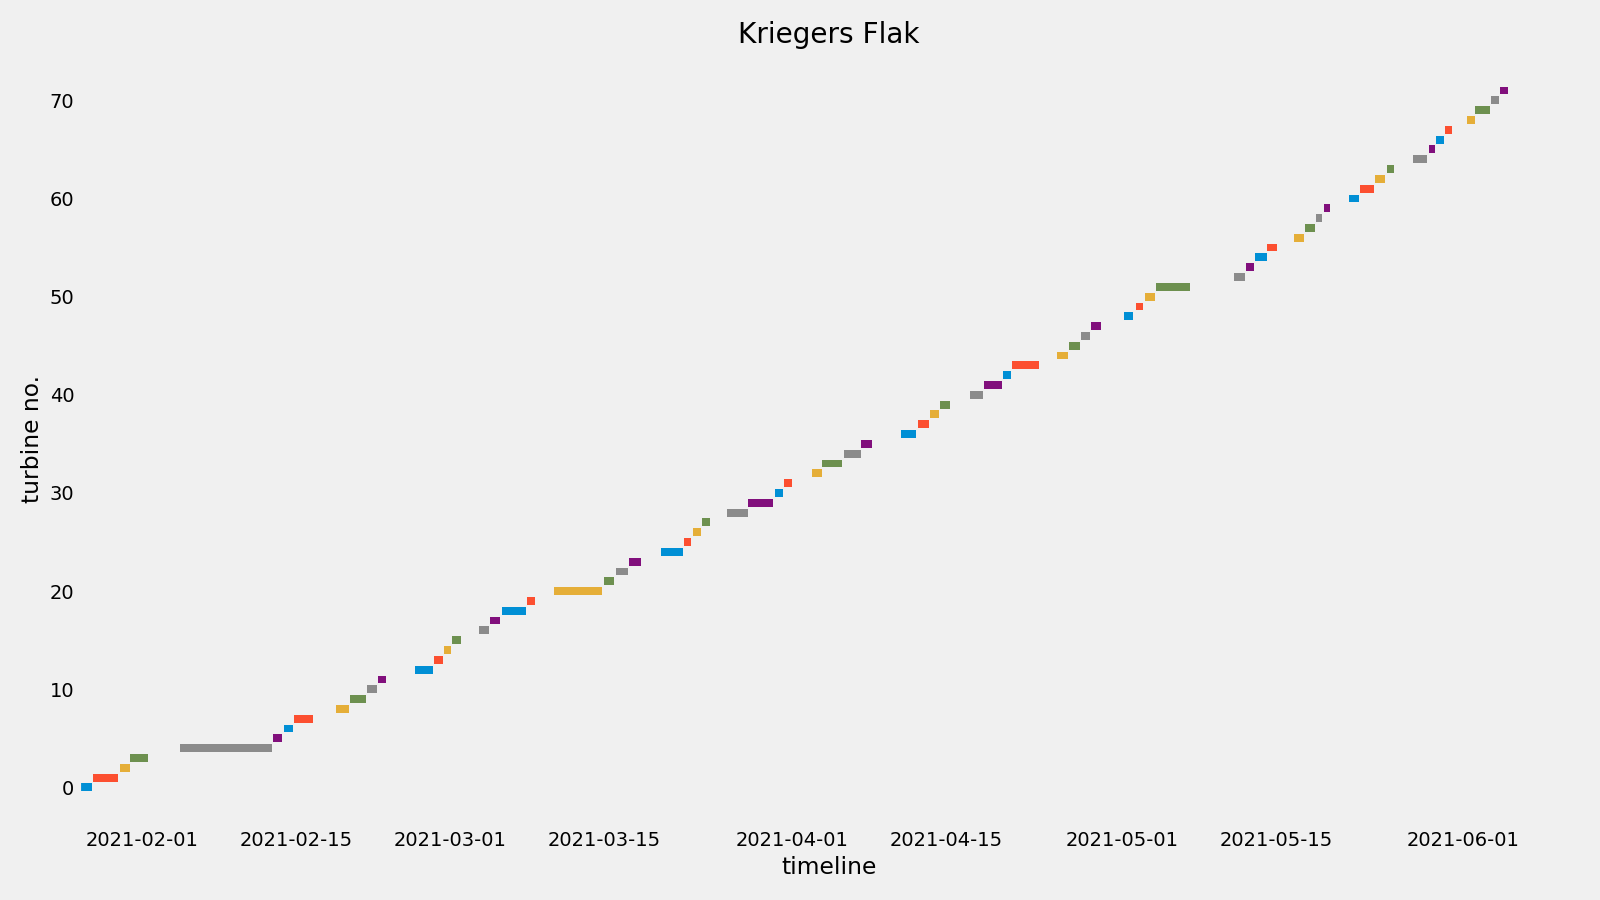

<IPython.core.display.Javascript object>


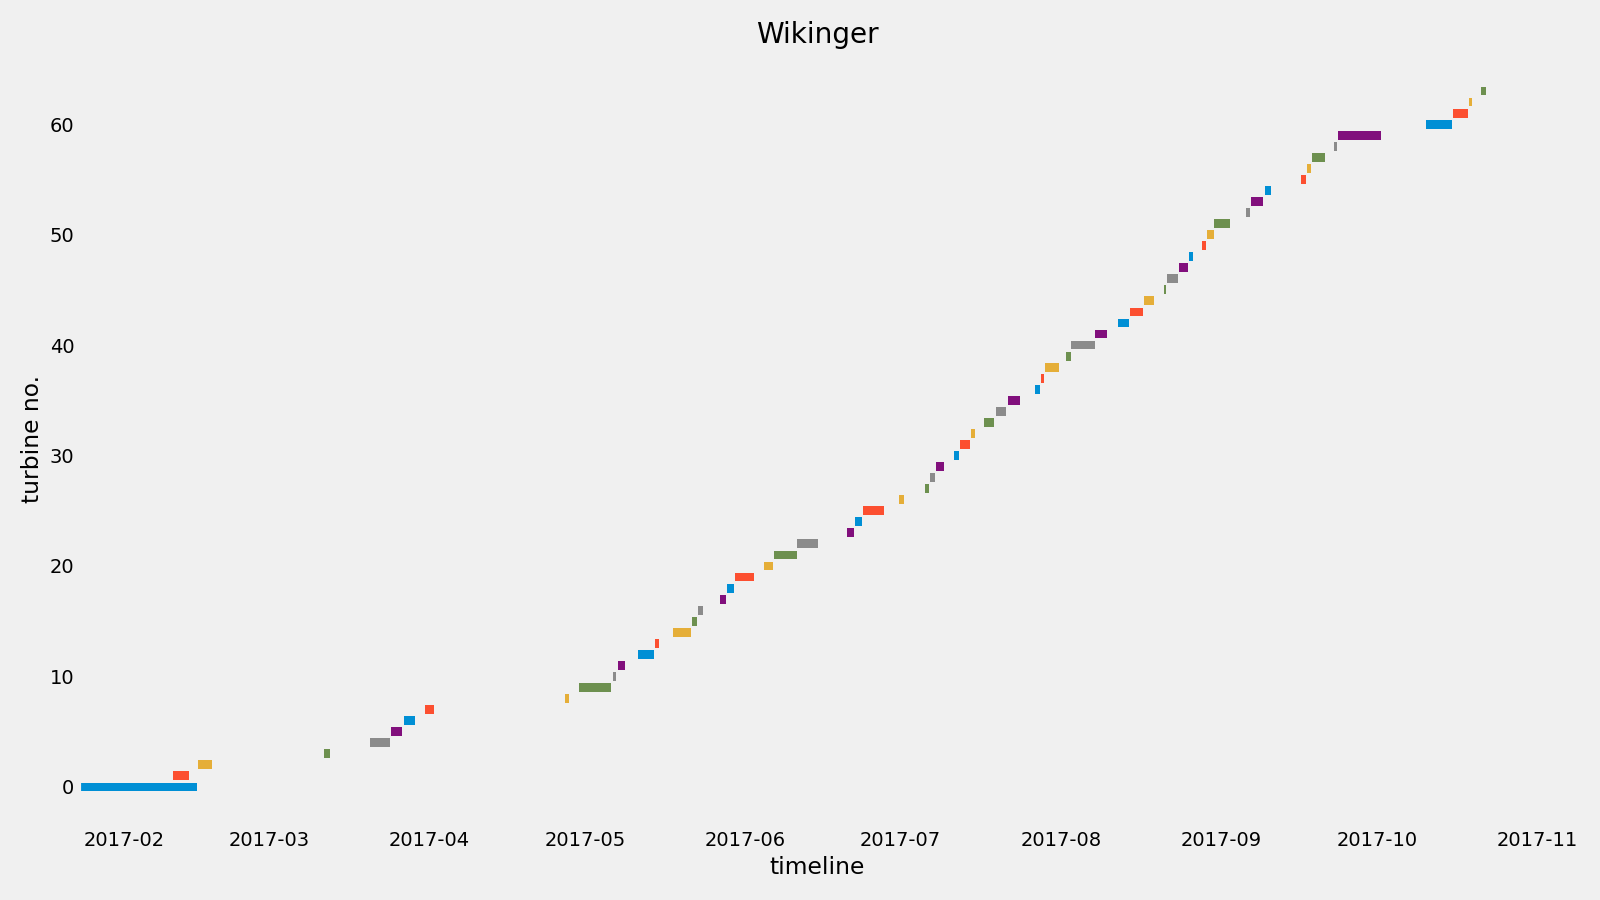

<IPython.core.display.Javascript object>


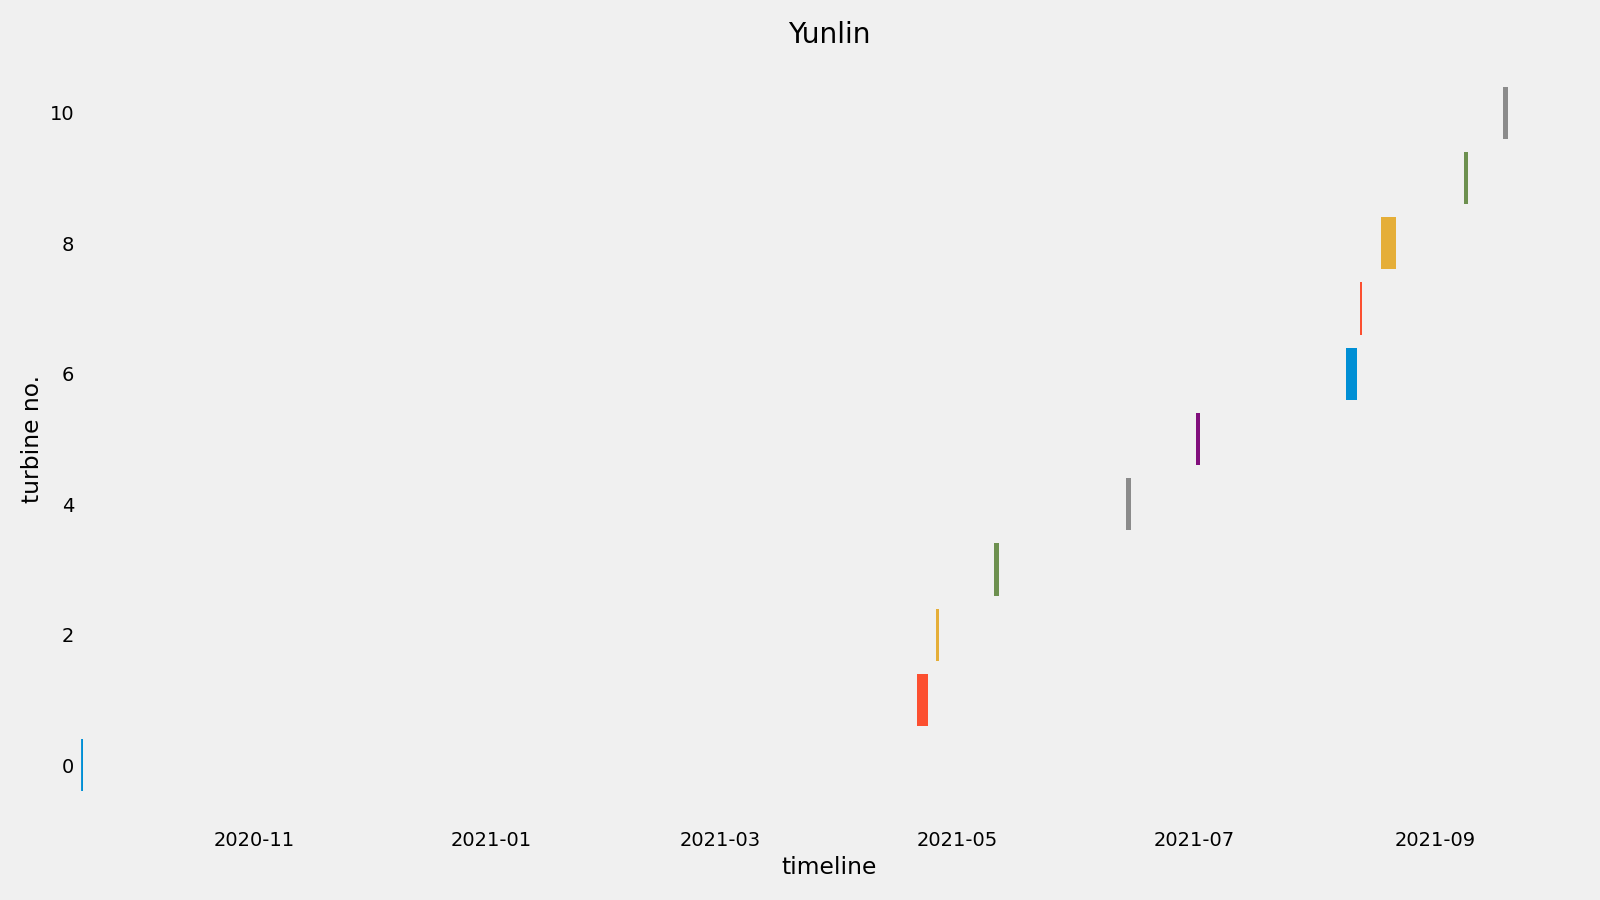

<IPython.core.display.Javascript object>


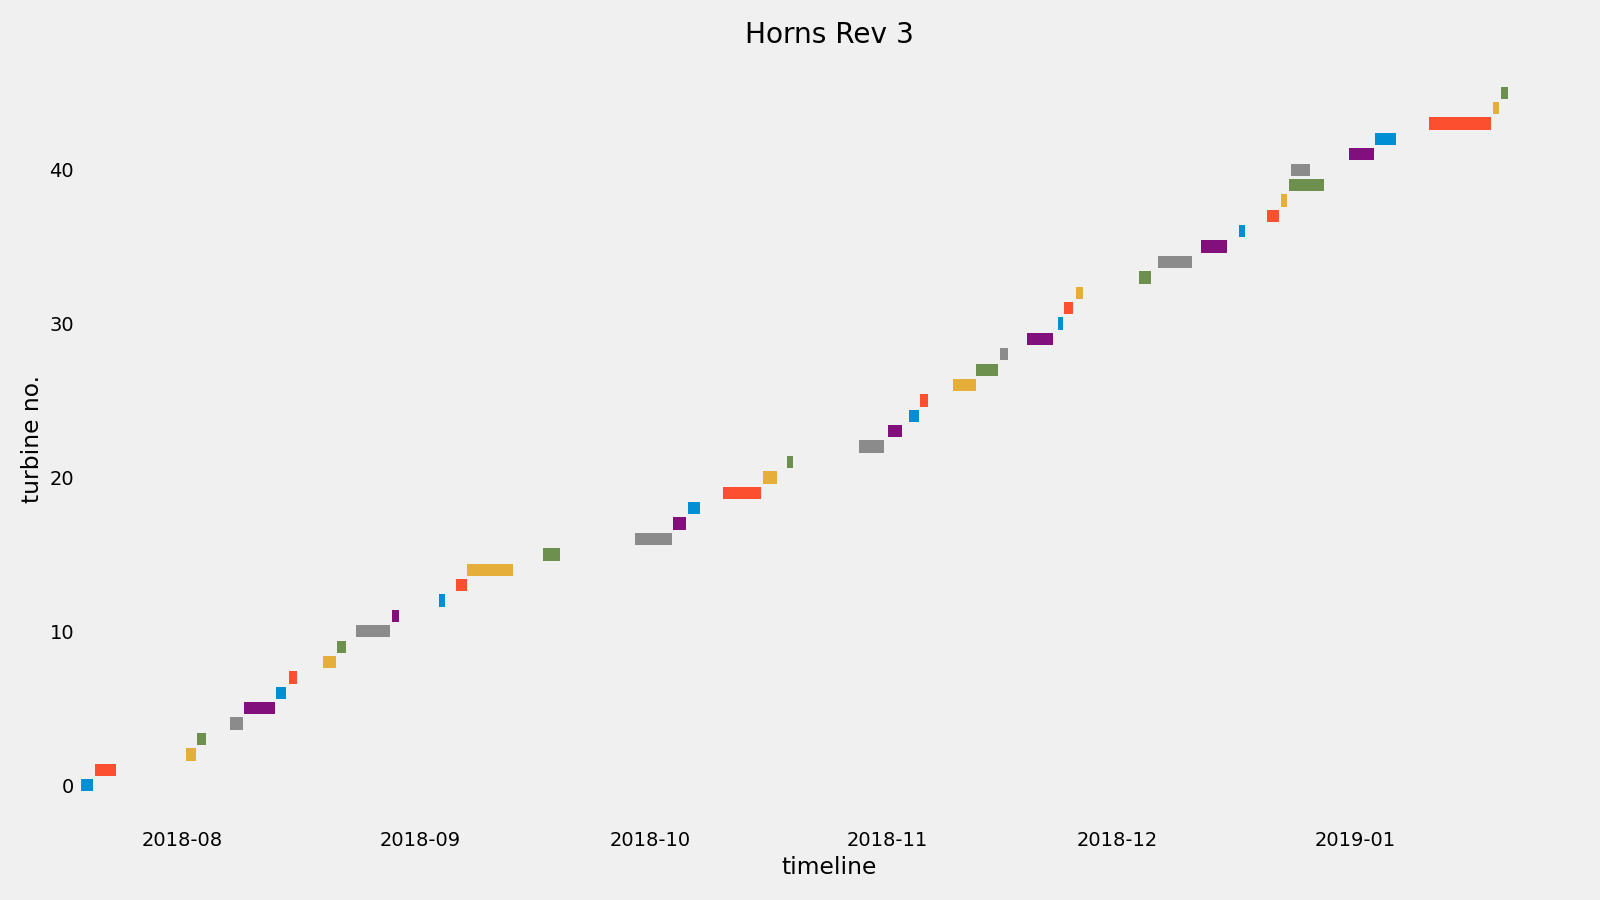

<IPython.core.display.Javascript object>


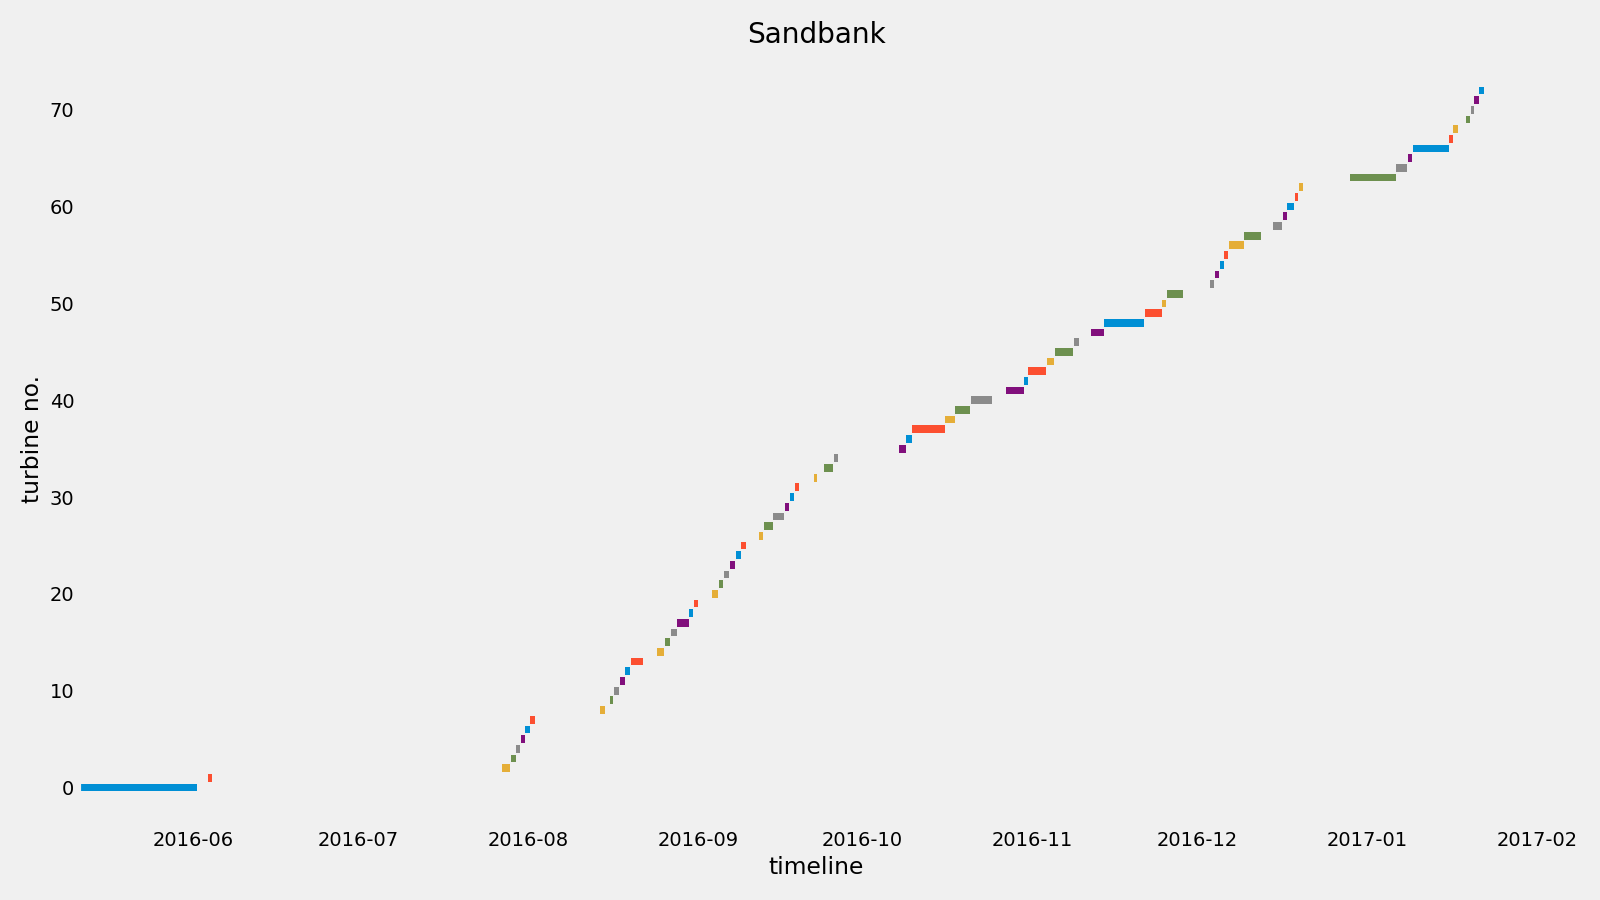

<IPython.core.display.Javascript object>


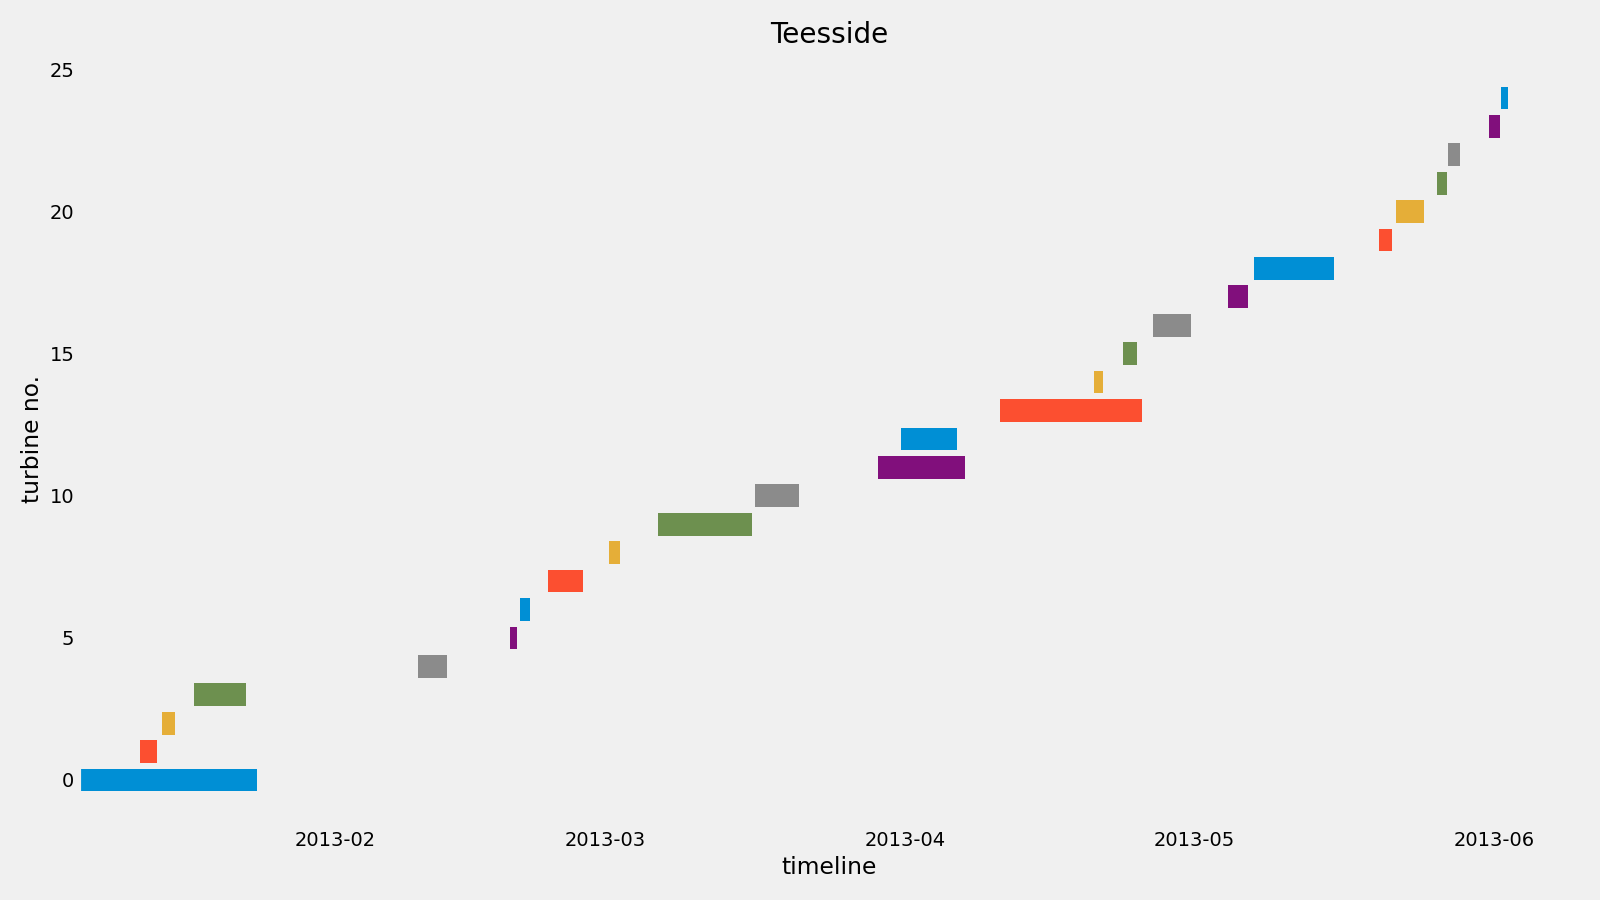

<IPython.core.display.Javascript object>


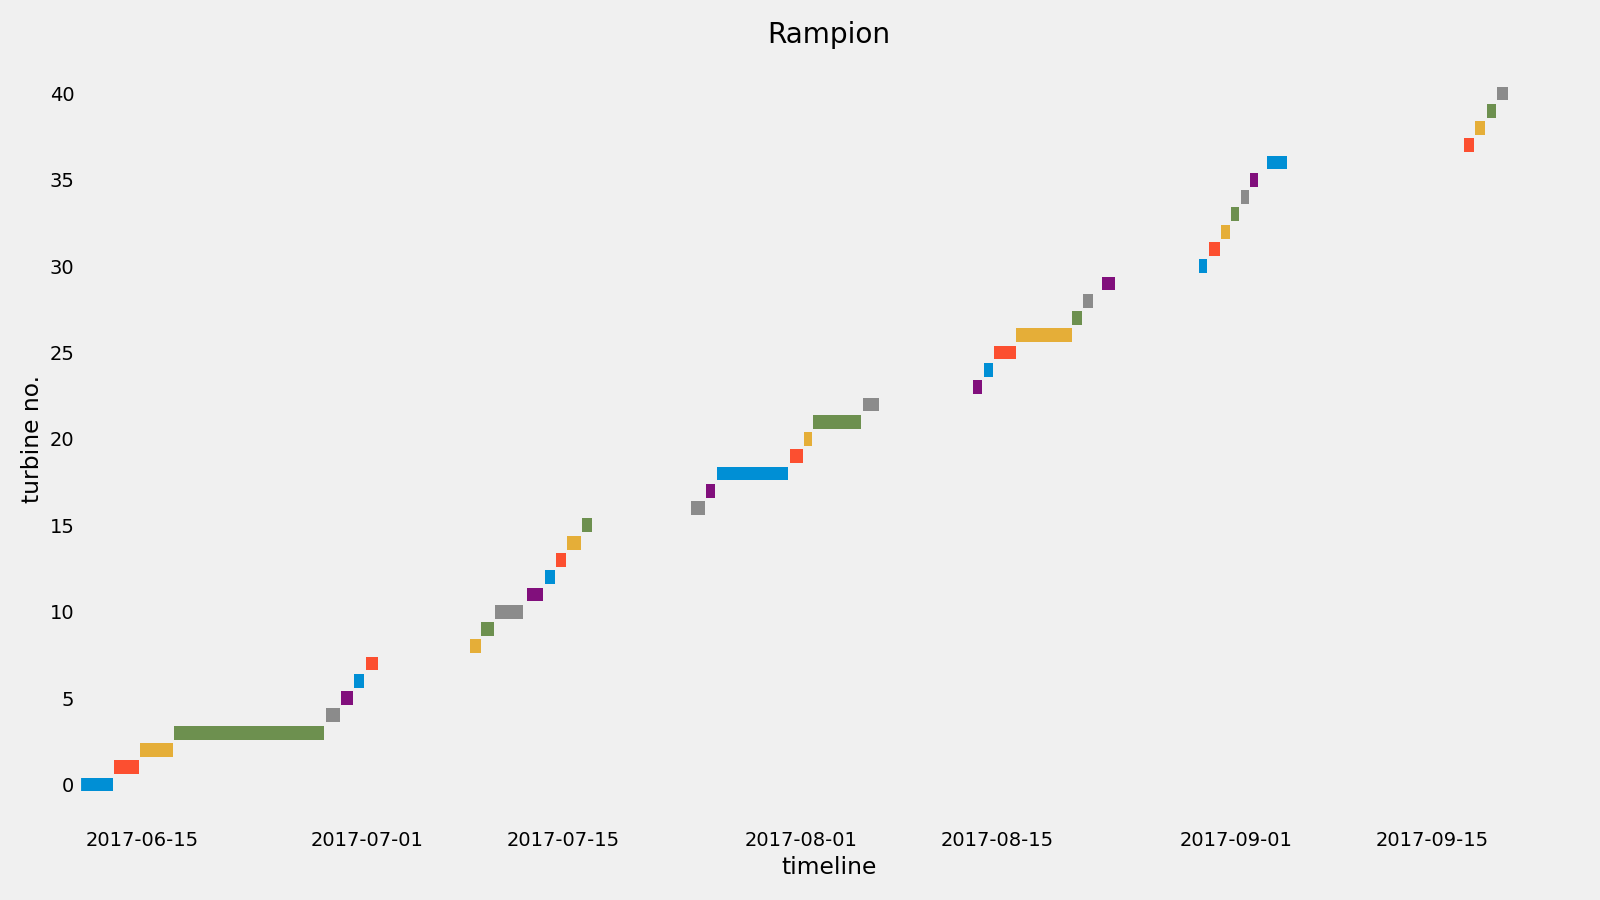

<IPython.core.display.Javascript object>


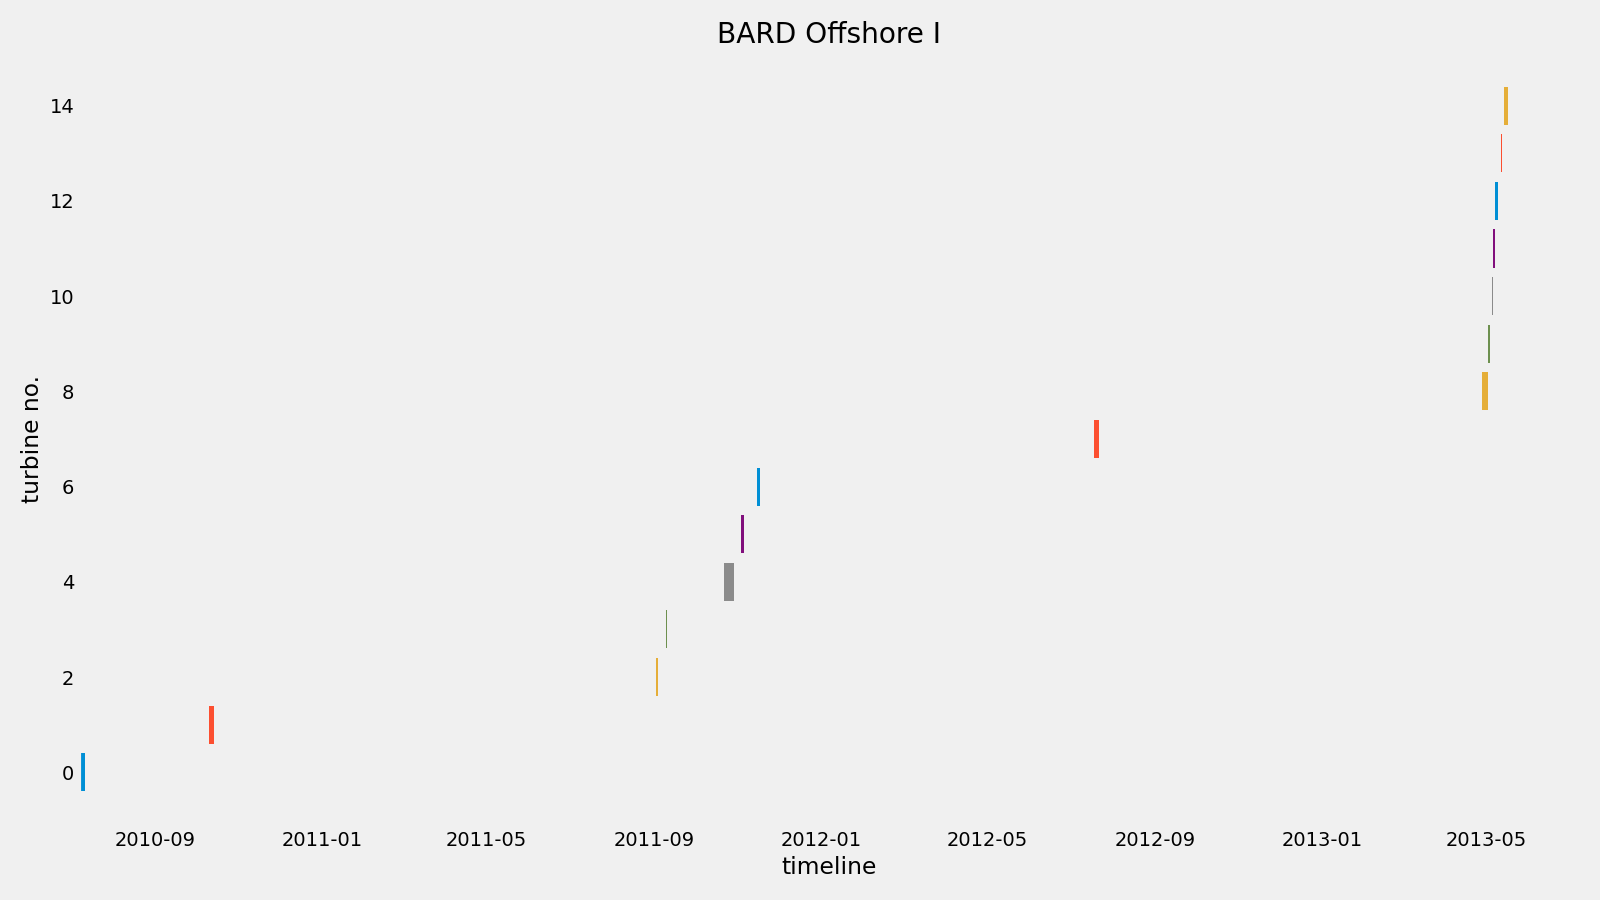

<IPython.core.display.Javascript object>


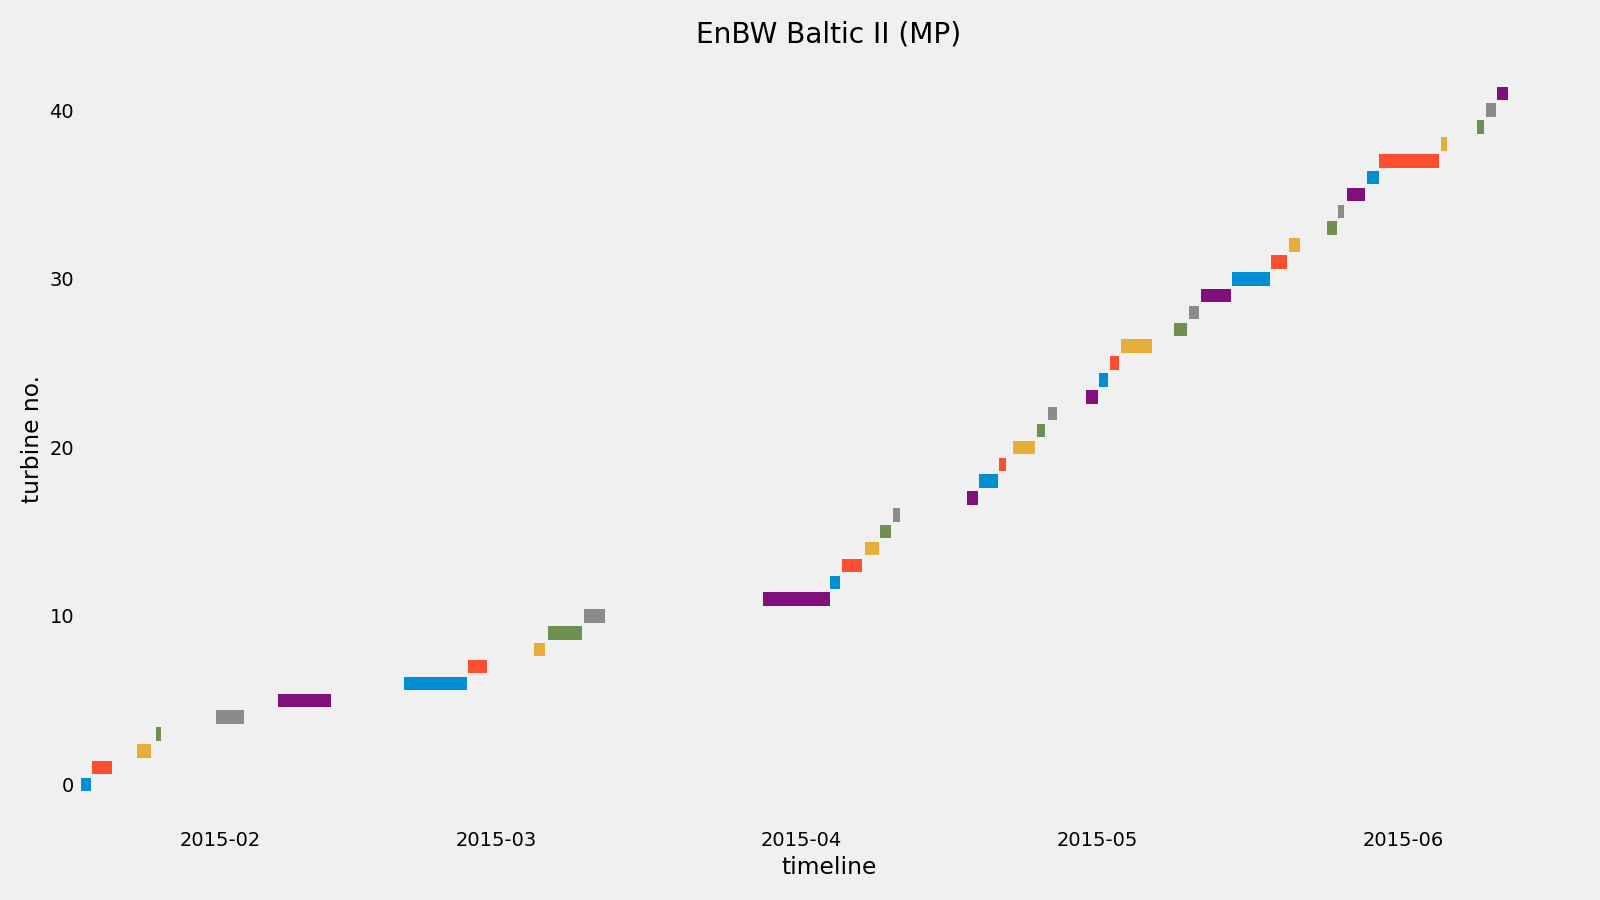

In [323]:
for key, windfarm in installations.items():
    plot_gantt(windfarm, title=windfarm_database.loc[key]['name'])